# Introduction

# Libraries and Modules

In [420]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import pandas_profiling
import itertools

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("GnBu_d")

import os, shutil

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, MultiLabelBinarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, cohen_kappa_score, accuracy_score, multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from mord import OrdinalRidge
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost

from IPython.display import Image
import pydotplus

import pickle

import shap

In [464]:
import preprocess as pre
import functions as func
%reload_ext autoreload
%autoreload 2

# Data

## Data Fields

* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to breed_labels.csv)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to breed_labels.csv
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to color_labels.csv)
* Color2 - Color 2 of pet (Refer to color_labels.csv)
* Color3 - Color 3 of pet (Refer to color_labels.csv)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to state_labels.csv)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* PetID - Unique hash ID of pet profile
* PhotoAmt - Total uploaded photos for this pet
* AdoptionSpeed - Categorical speed of adoption:
    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [3]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Final Project/Predicting-PetFinder-Adoption-Rate


In [4]:
df = pd.read_csv("dataset/petfinder-adoption-prediction/train/train.csv")
df.columns = df.columns.map(lambda x: x.lower())
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0  2     Nibble       3    299     0       1       1       7       0        
1  2     No Name Yet  1    265     0       1       1       2       0        

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0  1             1          2           2         2           1        
1  2             2          3           3         3           1        

   quantity  fee  state                         rescuerid  videoamt  \
0  1         100  41326  8480853f516546f6cf33aa88cd76c379  0          
1  1         0    41401  3082c7125d8fb66f7dd4bff4192c8b14  0          

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

       petid  photoamt  adoptionspeed  
0  86e1089a3  1.0       2              
1  6296e909a  2.0       0

## Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
type             14993 non-null int64
name             13736 non-null object
age              14993 non-null int64
breed1           14993 non-null int64
breed2           14993 non-null int64
gender           14993 non-null int64
color1           14993 non-null int64
color2           14993 non-null int64
color3           14993 non-null int64
maturitysize     14993 non-null int64
furlength        14993 non-null int64
vaccinated       14993 non-null int64
dewormed         14993 non-null int64
sterilized       14993 non-null int64
health           14993 non-null int64
quantity         14993 non-null int64
fee              14993 non-null int64
state            14993 non-null int64
rescuerid        14993 non-null object
videoamt         14993 non-null int64
description      14981 non-null object
petid            14993 non-null object
photoamt         14993 non-null float64
adoptionspe

In [6]:
breeds = pd.read_csv("dataset/petfinder-adoption-prediction/breed_labels.csv")
colors = pd.read_csv("dataset/petfinder-adoption-prediction/color_labels.csv")
states = pd.read_csv("dataset/petfinder-adoption-prediction/state_labels.csv")

df = pre.get_breed(df, breeds, "breed1")
df = pre.get_breed(df, breeds, "breed2")
df = pre.get_color(df, colors, "color1")
df = pre.get_color(df, colors, "color2")
df = pre.get_color(df, colors, "color3")
df = pre.get_state(df, states, "state")
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0  2     Nibble       3    299     0       1       1       7       0        
1  2     No Name Yet  1    265     0       1       1       2       0        

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0  1             1          2           2         2           1        
1  2             2          3           3         3           1        

   quantity  fee  state                         rescuerid  videoamt  \
0  1         100  41326  8480853f516546f6cf33aa88cd76c379  0          
1  1         0    41401  3082c7125d8fb66f7dd4bff4192c8b14  0          

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

       petid  photoamt  adoptionspeed           breed1_desc breed2_desc  \
0  86e1089a3  1.0       2              tabby                 NaN          
1  6296e909a  2.0       0              domestic_medium_hair  NaN          

  color1_desc color2_desc color3_desc    state_desc  
0  black       white       NaN         selangor      
1  black       brown       NaN         kuala_lumpur

In [7]:
#Rename the columns (add "_")
df.rename(mapper={
    "maturitysize": "maturity_size",
    "furlength": "fur_length",
    "rescuerid": "rescuer_id",
    "videoamt": "video_count",
    "photoamt": "photo_count",
    "petid": "pet_id",
    "adoptionspeed": "adoption_speed"
},
            axis=1,
            inplace=True)

In [8]:
#Add image filename and sentiment analysis of the pet description

images_folder_path = "dataset/petfinder-adoption-prediction/train_images/"
df = pre.get_image_filename(df, images_folder_path)

sentiment_folder_path = "dataset/petfinder-adoption-prediction/train_sentiment/"
df = pre.get_sentiment_analysis(df, sentiment_folder_path)

df.head(2)

There are a total of  58311  pet images.
341 pets have no images.


type         name  age  breed1  breed2  gender  color1  color2  color3  \
0  2     Nibble       3    299     0       1       1       7       0        
1  2     No Name Yet  1    265     0       1       1       2       0        

   maturity_size  fur_length  vaccinated  dewormed  sterilized  health  \
0  1              1           2           2         2           1        
1  2              2           3           3         3           1        

   quantity  fee  state                        rescuer_id  video_count  \
0  1         100  41326  8480853f516546f6cf33aa88cd76c379  0             
1  1         0    41401  3082c7125d8fb66f7dd4bff4192c8b14  0             

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

      pet_id  photo_count  adoption_speed           breed1_desc breed2_desc  \
0  86e1089a3  1.0          2               tabby                 NaN          
1  6296e909a  2.0          0               domestic_medium_hair  NaN          

  color1_desc color2_desc color3_desc    state_desc         filename  \
0  black       white       NaN         selangor      86e1089a3-1.jpg   
1  black       brown       NaN         kuala_lumpur  6296e909a-1.jpg   

   desc_score  desc_magnitude  desc_sentences_score_sum  \
0  0.3         2.4             1.8                        
1 -0.2         0.7            -0.5                        

   desc_sentences_score_avg  
0  0.30                      
1 -0.25

In [9]:
#Rearrange the column headers
df = df[[
    "adoption_speed", "pet_id", "type", "name", "age", "breed1", "breed1_desc",
    "breed2", "breed2_desc", "gender", "color1", "color1_desc", "color2",
    "color2_desc", "color3", "color3_desc", "maturity_size", "fur_length",
    "vaccinated", "dewormed", "sterilized", "health", "quantity", "fee",
    "state", "state_desc", "rescuer_id", "video_count", "photo_count", "filename",
    "description", "desc_score", "desc_magnitude", "desc_sentences_score_sum", "desc_sentences_score_avg"
]]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 0 to 14992
Data columns (total 35 columns):
adoption_speed              14993 non-null int64
pet_id                      14993 non-null object
type                        14993 non-null int64
name                        13736 non-null object
age                         14993 non-null int64
breed1                      14993 non-null int64
breed1_desc                 14988 non-null object
breed2                      14993 non-null int64
breed2_desc                 4231 non-null object
gender                      14993 non-null int64
color1                      14993 non-null int64
color1_desc                 14993 non-null object
color2                      14993 non-null int64
color2_desc                 10522 non-null object
color3                      14993 non-null int64
color3_desc                 4389 non-null object
maturity_size               14993 non-null int64
fur_length                  14993 non-null int64
vacc

In [10]:
# Save this version
df.to_csv("pets.csv", index=False)

In [162]:
#Run a profile report
petfinder_report = df.profile_report(
    title="Petfinder.my Detailed Profile Report",
    correlation_threshold_pearson=.9,
    sort="None")
petfinder_report.to_file(output_file="pets.html")
petfinder_report

### Adoption Speed Rate

    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [163]:
pets = pd.read_csv("pets.csv")
pets.shape

(14993, 35)

In [164]:
display(pd.DataFrame((pets.adoption_speed.value_counts(normalize=True)*100)).head(20))

adoption_speed
4  27.993063     
2  26.925899     
3  21.736811     
1  20.609618     
0  2.734609

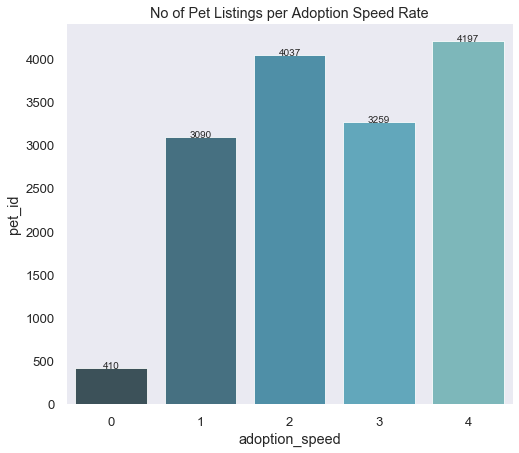

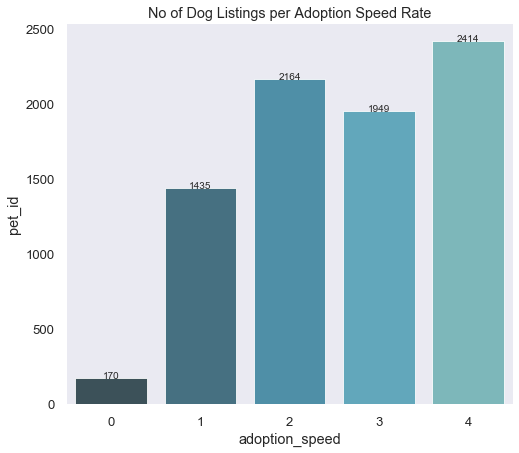

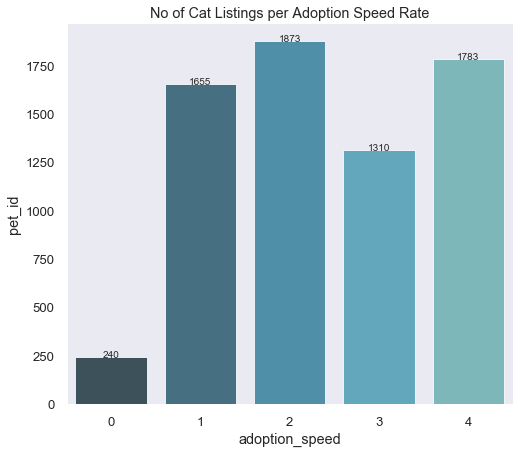

In [165]:
df_plot = pets.groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Pet Listings per Adoption Speed Rate")

df_plot = pets.query("type ==1").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Dog Listings per Adoption Speed Rate")

df_plot = pets.query("type ==2").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Cat Listings per Adoption Speed Rate")

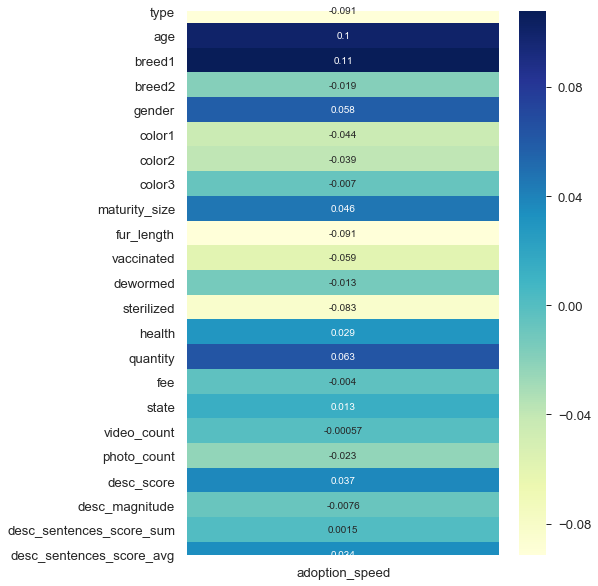

In [168]:
plt.figure(figsize=(7, 10))
sns.heatmap(data = pets.corr()[["adoption_speed"]].iloc[1:,:], annot=True, cmap="YlGnBu");

The dataset is imbalanced mainly because of class 0 (3%). This class means the pets were adopted the same day they were listed. Upon checking with Petfinder.my....XXXXXX

Also the purpose of this project is to .....

Based on the above, I will move class 0 to 1.  Class 1 latter means the pets were adopted within the week of being listed.

### Type

Type of animal (1 = Dog, 2 = Cat)

In [169]:
display(pd.DataFrame((pets.type.value_counts(normalize=True)*100)))

type
1  54.238645
2  45.761355

### Name

### Age

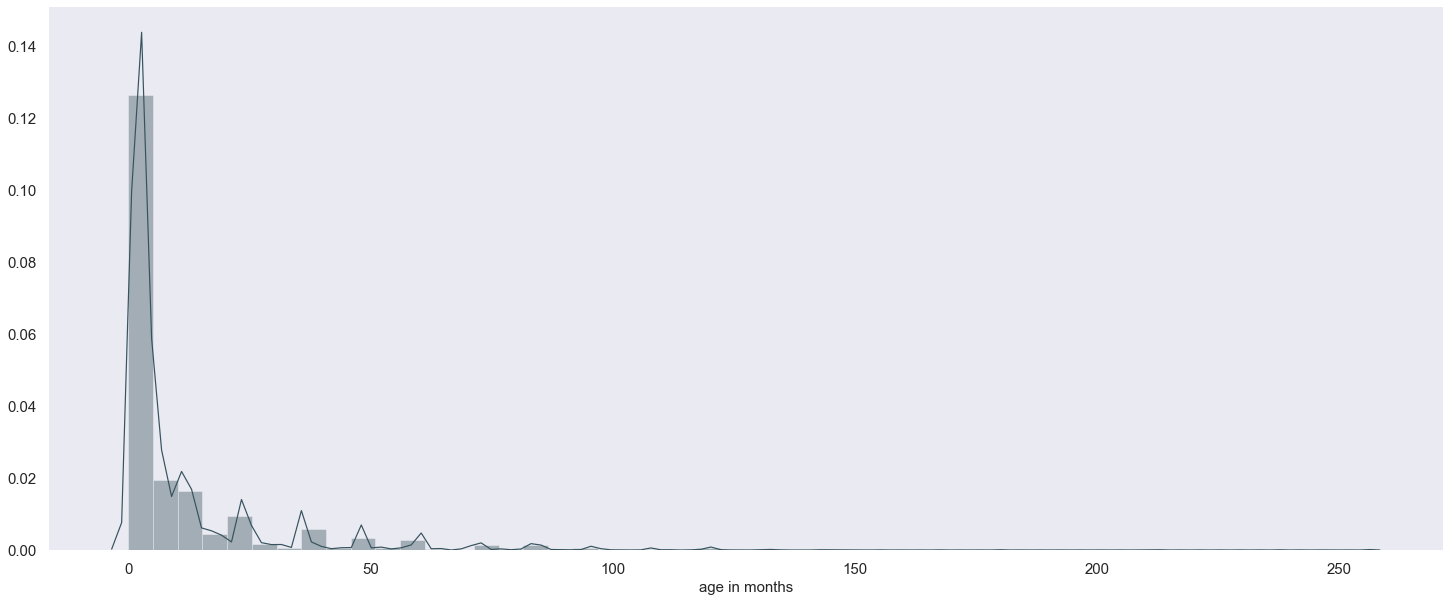

In [170]:
pre.plot_hist(pets["age"], "age in months", (25, 10))

In [171]:
# Around 52% of the pets is between 1-3 months old.

display(pd.DataFrame((pets.age.value_counts(normalize=True)*100)).head(20))

age
2   23.364237
1   15.367171
3   13.112786
4   7.396785 
12  6.449677 
24  4.342026 
5   3.968519 
6   3.721737 
36  2.781298 
8   2.060962 
7   1.874208 
48  1.607417 
60  1.327286 
9   1.227239 
0   1.193890 
18  1.100514 
10  1.080504 
72  0.693657 
84  0.680317 
11  0.626959

In [172]:
#There are 392 pets that are more than 5 years old.
#First 2 lines are duplicates. I will remove one entry at the Pre-processing section.

pets.query("age > 60")[["adoption_speed","pet_id", "age", "description"]].sort_values("age", ascending = False)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
#I have checked the website to know why pet_id 5971c2462 is 255 months old.
#Fifi was listed on Petfinder.my in Feb 2012.

images_folder_path = "dataset/petfinder-adoption-prediction/train_images/"
pre.get_pet_image(images_folder_path, "5971c2462")
pre.get_image("dataset/", "fifi.png")

In [ ]:
df_plot = pets.query("age <= 12").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "0-12 Month Old Pets per Adoption Speed Rate")
display(pd.DataFrame((pets.query("age <= 12").adoption_speed.value_counts(normalize=True)*100)).T)

df_plot = pets.query("age > 12").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", ">12 Month Old Pets per Adoption Speed Rate")
display(pd.DataFrame((pets.query("age > 12").adoption_speed.value_counts(normalize=True)*100)).T)

In [ ]:
# df_plot = pets.groupby("age").count()[["pet_id"]].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months)]", figsize = [30, 10])

# df_plot = pets.query("adoption_speed <= 1").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed <=1]", figsize = [25, 10])

# df_plot = pets.query("adoption_speed == 2").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed = 2]", figsize = [25, 10])

# df_plot = pets.query("adoption_speed == 3").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed = 3]", figsize = [25, 10])

# df_plot = pets.query("adoption_speed == 4").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed = 4]", figsize = [25, 10])

In [ ]:
df_plot = pets.groupby(["age", "adoption_speed"]).count().iloc[:,:1].reset_index()
pre.plot_bar_hue(df_plot.query("age <= 12"), "age", "pet_id", "adoption_speed", "Below 12 Month Old Pets", figsize = (25, 10))
pre.plot_bar_hue(df_plot.query("age <= 24"), "age", "pet_id", "adoption_speed", "13-24 Month Old Pets", figsize = (25, 10))

In [ ]:
df_plot = pets.query("age == 0").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Pet Listings with Missing Age Information")

* Most of the pets are 1-3 months old.
* Multiples of 12 were used as placeholders. 
* Only 2782 (19%) are more than 12 months old. Some of them are even more than 20 years old. 
* Some of them have been listed for a while.  
* 0-12 month old pets are adopted faster than >12 month.
* Age has a very low correlation with adoption speed.

I see no issue with age = 0 at adoption speed of 0-2 as this means the pets were adopted before they reached the age of 1 month. 

Adoption speed rates at 3 & 4 mean that the pets were already been listed for more than a month.  I will be removing these listings with age = 0 (0.5% of the dataset) as these seem to be errors.

In [ ]:
len(pets.query("age <= 12"))/len(pets)

### Breed

In [ ]:
df_plot = pets[["breed1_desc", "adoption_speed",
                "pet_id"]].groupby(["breed1_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).iloc[:40, ].reset_index()

pre.plot_bar_hue(df_plot, "breed1_desc", "pet_id", "adoption_speed", 
             "Top Breed 1: No of Pets Listings", figsize = (25,10),rotate = True)

df_plot = pets[["breed2_desc", "adoption_speed",
                "pet_id"]].groupby(["breed2_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).iloc[:40, ].reset_index()

pre.plot_bar_hue(df_plot, "breed2_desc", "pet_id", "adoption_speed", 
             "Top Breed 2: No of Pets Listings", figsize = (25,10),rotate = True)


In [ ]:
display(pd.DataFrame((pets.breed1_desc.value_counts(normalize=True)*100)).head(10))
display(pd.DataFrame((pets.breed2_desc.value_counts(normalize=True)*100).head(10)))

In [ ]:
# Most of the mixed bred pets are adopted within one month.
# Percentage for each adoption speed rate shown below. First table is for breed1, second is for breed2.

display(pd.DataFrame((pets.query("breed1 == 307").adoption_speed.value_counts(normalize=True)*100)))
display(pd.DataFrame((pets.query("breed2 == 307").adoption_speed.value_counts(normalize=True)*100)))

In [ ]:
# Most of the domestic pets are adopted within one month as well. 
# Percentage for each adoption speed rate shown below. First table is for breed1, second is for breed2.

q1 = """SELECT * FROM pets WHERE breed1_desc LIKE "%Domestic%";"""
df1 = pysqldf(q1)

q2 = """SELECT * FROM pets WHERE breed2_desc LIKE "%Domestic%";"""
df2 = pysqldf(q2)

display(pd.DataFrame((df1.adoption_speed.value_counts(normalize=True)*100)))
display(pd.DataFrame((df2.adoption_speed.value_counts(normalize=True)*100)))

In [ ]:
q = """SELECT breed1_desc, fur_length, count(breed1_desc) as listing_count FROM pets WHERE breed1_desc LIKE "%Domestic%" GROUP by breed1_desc, fur_length ORDER by listing_count DESC;"""
table = pysqldf(q)
table

* Mixed bred and domestic are the most common values.  Both breed types are adopted within one month.
* 40% and 41% of breed 1 and 2 columns, respectively, are mixed bred.
* 35% and 25% of breed 1 and 2 columns, respectively, are domestic.
* The domestic breed types are not consistent with the fur length.  

Upon checking the website, the breed fields are drop downs while the fur lengths are radio buttons.  The fur length would be more accurately selected as compared to the specific type of "Domestic" breed. I will be changing all these to "Domestic" only and assume that the fur length is correct.

Also I will be adding a column that will categorise the listings into Mixed Bred, Pure Bred, Domestic

### Gender

(1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

In [ ]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar(df_plot.groupby("gender").sum().reset_index(), "gender", "pet_id",
             "No of Pets Listings per Gender", rotate = False)

display(pd.DataFrame((pets.gender.value_counts(normalize=True)*100)))

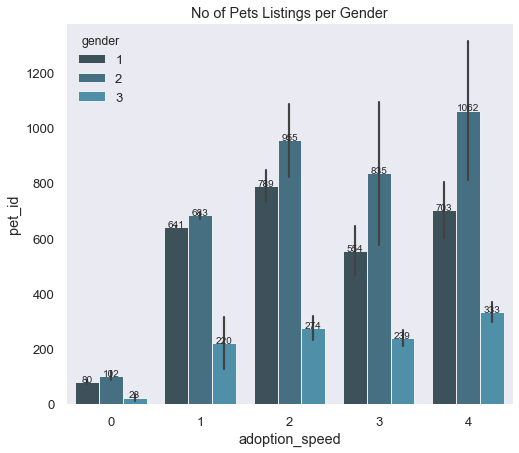

In [173]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot,"adoption_speed", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

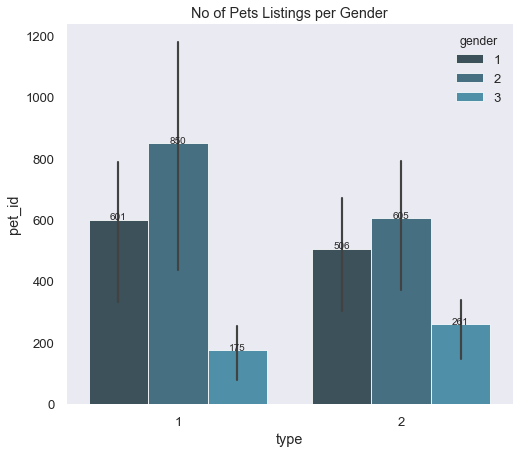

In [174]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender", "adoption_speed", "type"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot,"type", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

### Color

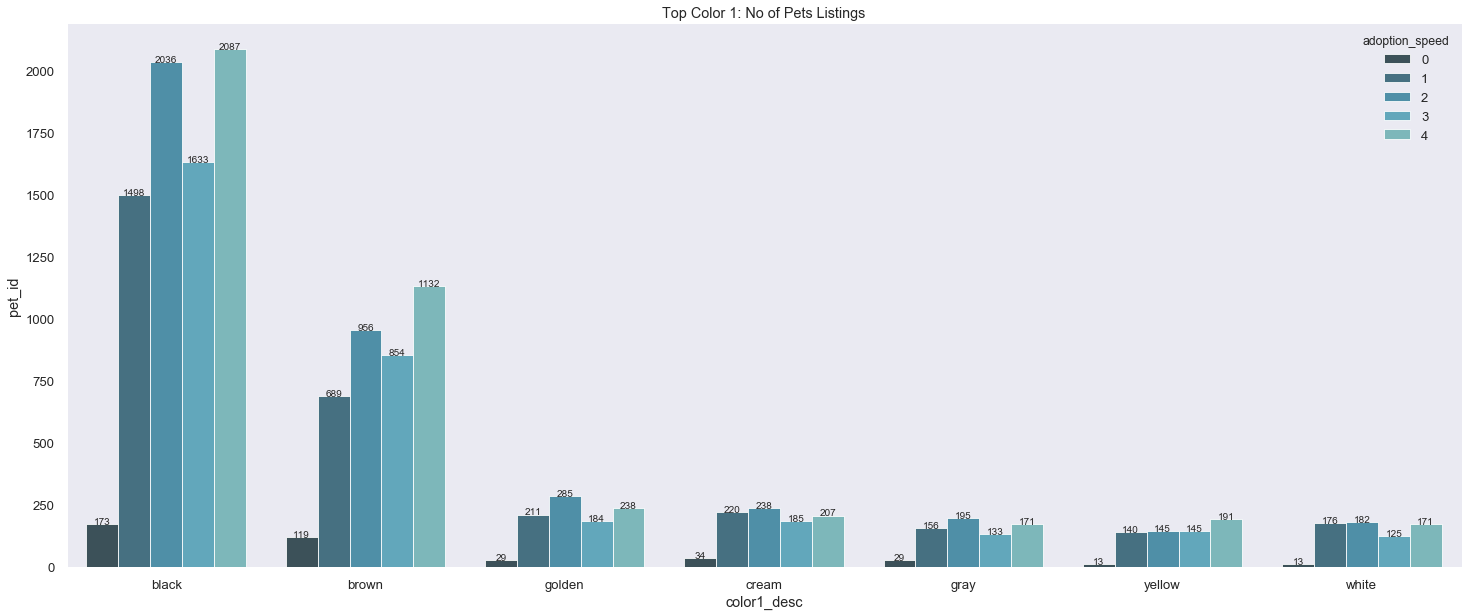

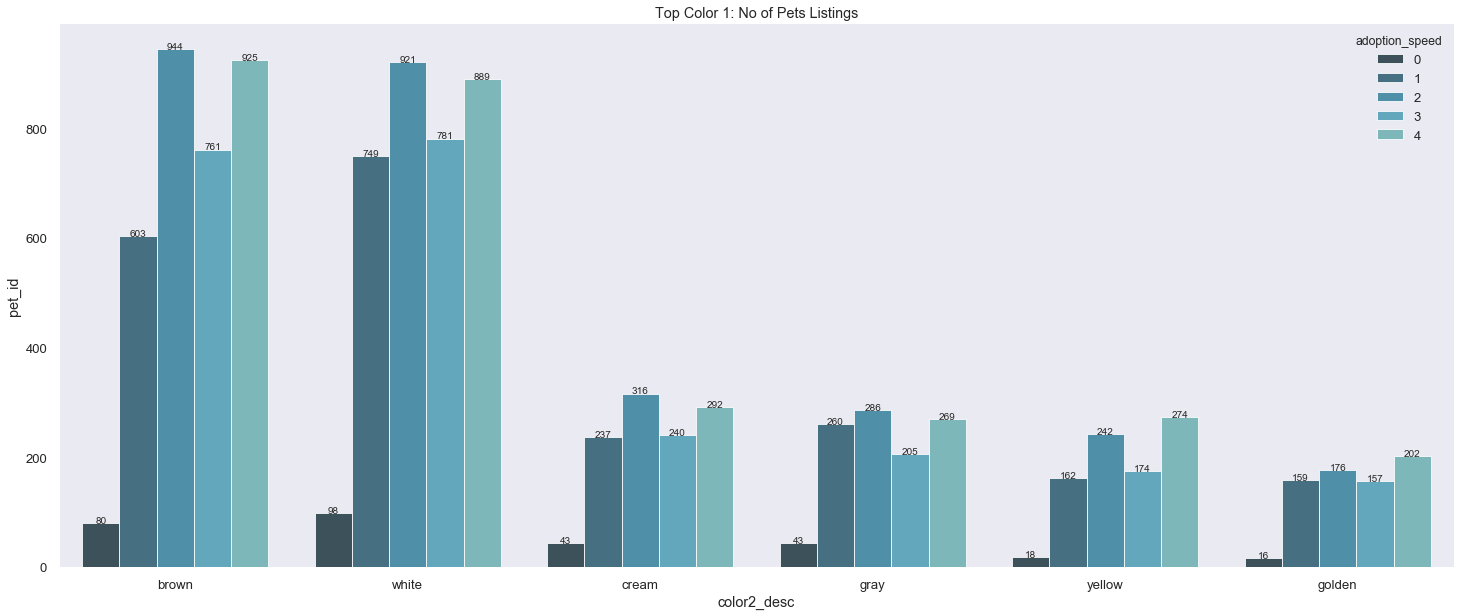

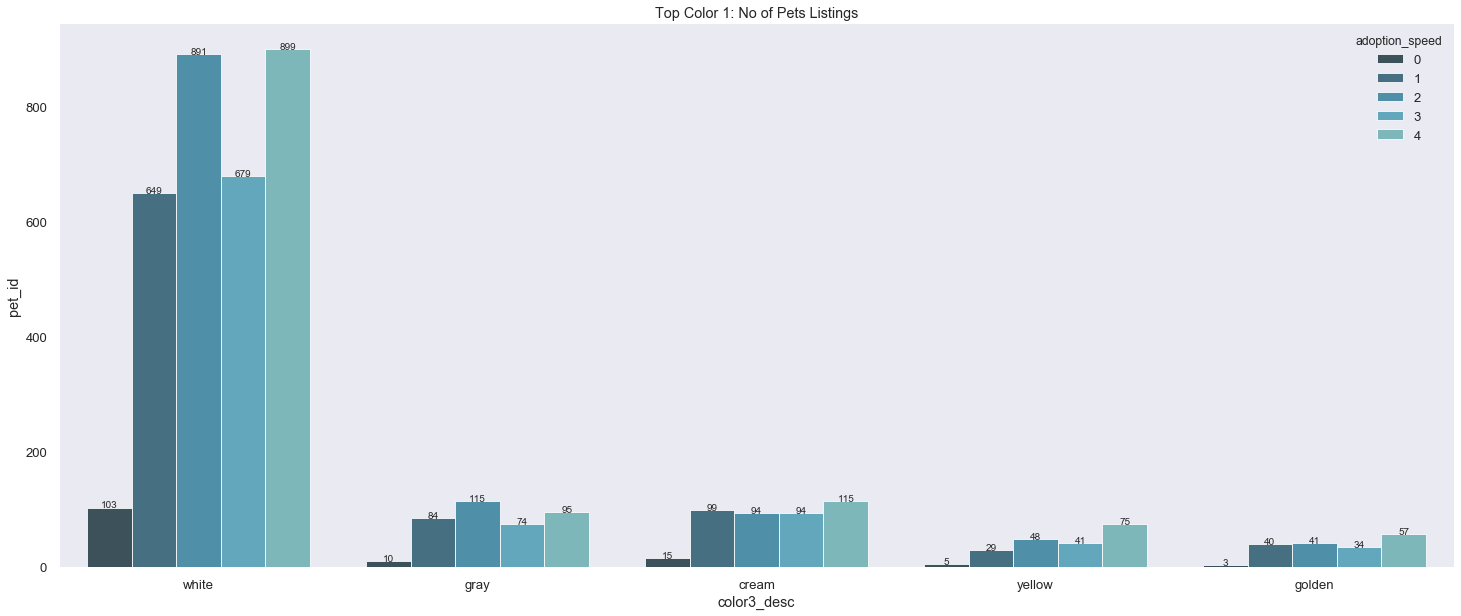

In [175]:
df_plot = pets[["color1_desc", "adoption_speed",
                "pet_id"]].groupby(["color1_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "color1_desc", "pet_id", "adoption_speed", 
             "Top Color 1: No of Pets Listings", figsize = (25,10))

df_plot = pets[["color2_desc", "adoption_speed",
                "pet_id"]].groupby(["color2_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "color2_desc", "pet_id", "adoption_speed", 
             "Top Color 1: No of Pets Listings", figsize = (25,10))

df_plot = pets[["color3_desc", "adoption_speed",
                "pet_id"]].groupby(["color3_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "color3_desc", "pet_id", "adoption_speed", 
             "Top Color 1: No of Pets Listings", figsize = (25,10))

In [176]:
petscopy = pets.copy().fillna("")
petscopy["color_combination"] = pd.Series()

for i in range(len(petscopy)):
    petscopy["color_combination"].iloc[i] = "".join(sorted([petscopy["color1_desc"].iloc[i], petscopy["color2_desc"].iloc[i], petscopy["color3_desc"].iloc[i]]))  

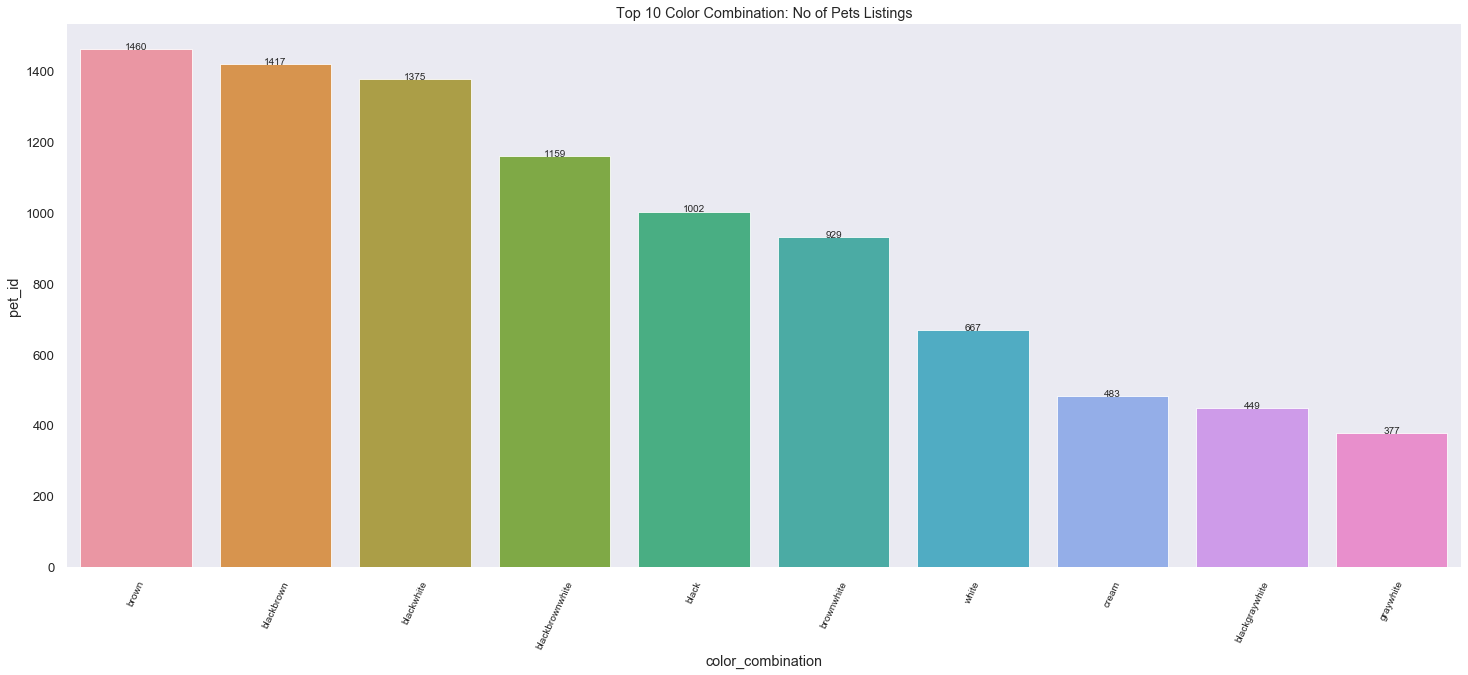

In [196]:
df_plot = petscopy[["color_combination", "pet_id"]].groupby(["color_combination"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar(df_plot.iloc[:10,:],
             "color_combination",
             "pet_id",
             "Top 10 Color Combination: No of Pets Listings",
             figsize=(25, 10),
             rotate=True)

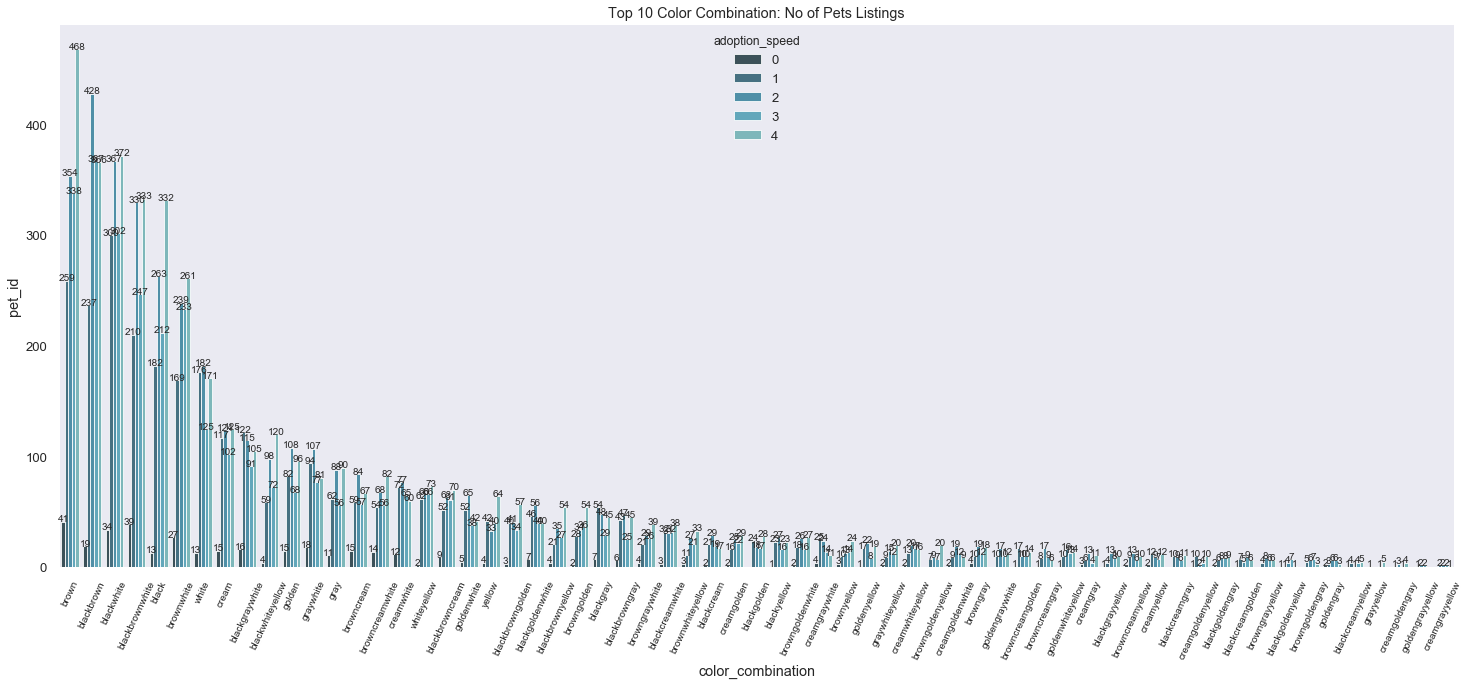

In [178]:
df_plot = petscopy[["color_combination", "adoption_speed", "pet_id"]].groupby([
    "color_combination", "adoption_speed"
]).count().sort_values("color_combination", ascending=False).reset_index().sort_values("pet_id", ascending=False)

pre.plot_bar_hue(df_plot,
                 "color_combination",
                 "pet_id",
                 "adoption_speed",
                 "Top 10 Color Combination: No of Pets Listings",
                 figsize=(25, 10),
                 rotate=True)

### Size at Maturity

(1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

In [179]:
display(pd.DataFrame((pets.maturity_size.value_counts(normalize=True)*100)))

maturity_size
2  68.732075    
1  22.643900    
3  8.403922     
4  0.220103

### Fur Length

(1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

In [180]:
display(pd.DataFrame((pets.fur_length.value_counts(normalize=True)*100)))

fur_length
1  58.747415 
2  35.756686 
3  5.495898

### Vaccinated

(1 = Yes, 2 = No, 3 = Not Sure)

In [181]:
display(pd.DataFrame((pets.vaccinated.value_counts(normalize=True)*100)))

vaccinated
2  48.202494 
1  39.338358 
3  12.459148

### Dewormed

(1 = Yes, 2 = No, 3 = Not Sure)

In [182]:
display(pd.DataFrame((pets.dewormed.value_counts(normalize=True)*100)))

dewormed
1  56.006136
2  32.114987
3  11.878877

### Spayed / Neutered

(1 = Yes, 2 = No, 3 = Not Sure)

In [183]:
display(pd.DataFrame((pets.sterilized.value_counts(normalize=True)*100)))

sterilized
2  67.211365 
1  20.682985 
3  12.105649

### Health Condition

(1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

In [184]:
display(pd.DataFrame((pets.health.value_counts(normalize=True)*100)))

health
1  96.565064
2  3.208164 
3  0.226772

### Quantity

In [185]:
display(pd.DataFrame((pets.quantity.value_counts(normalize=True)*100)))

quantity
1   77.135997
2   9.484426 
3   4.842260 
4   3.541653 
5   2.221036 
6   1.233909 
7   0.560261 
8   0.346829 
9   0.220103 
10  0.126726 
20  0.080037 
11  0.066698 
12  0.040019 
15  0.026679 
17  0.020009 
16  0.020009 
13  0.013340 
14  0.013340 
18  0.006670

### Adoption Fee

In [186]:
display(pd.DataFrame((pets.fee.value_counts(normalize=True)*100)))

fee
0    84.459414
50   3.121457 
100  2.721270 
200  1.460682 
150  1.080504 
..        ... 
210  0.006670 
99   0.006670 
330  0.006670 
75   0.006670 
599  0.006670 

[74 rows x 1 columns]

### Location

State location in Malaysia

In [187]:
display(pd.DataFrame((pets.state_desc.value_counts(normalize=True)*100)))

state_desc
selangor         58.120456 
kuala_lumpur     25.645301 
pulau_pinang     5.622624  
johor            3.381578  
perak            2.801307  
negeri_sembilan  1.687454  
melaka           0.913760  
kedah            0.733676  
pahang           0.566931  
terengganu       0.173414  
sabah            0.146735  
kelantan         0.100047  
sarawak          0.086707  
labuan           0.020009

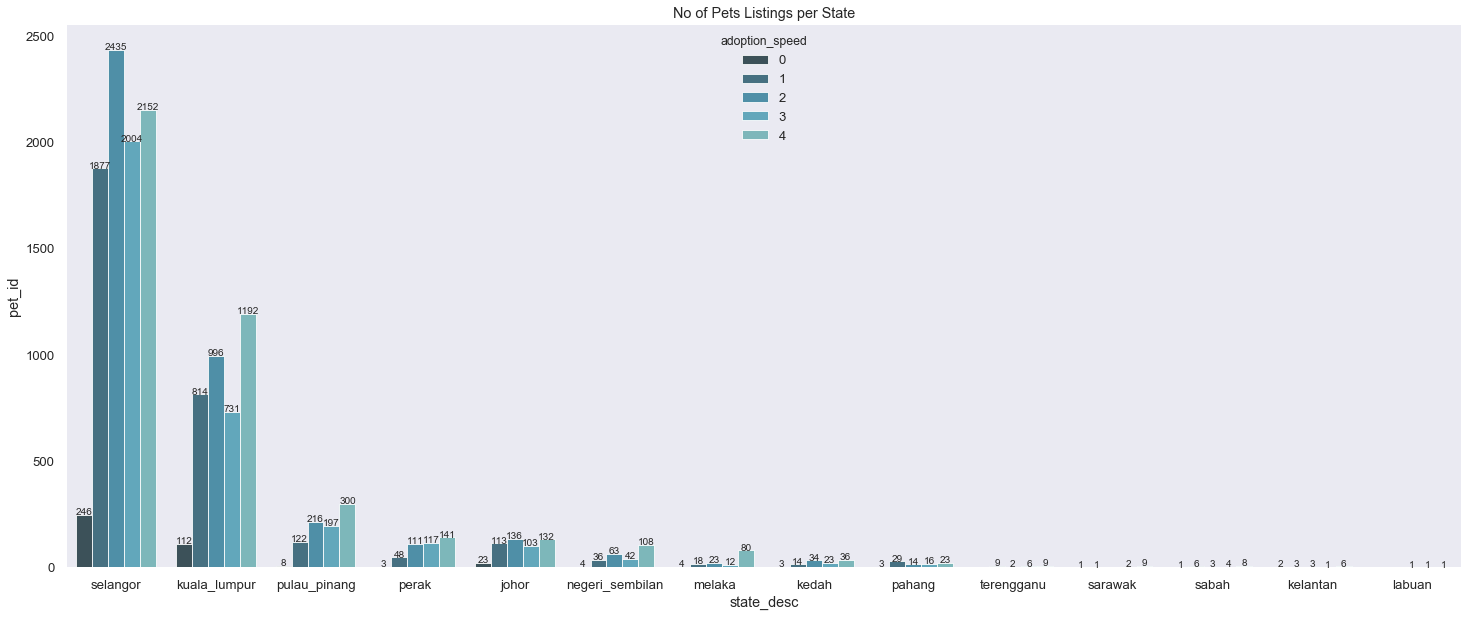

In [188]:
df_plot = pets[["state_desc", "adoption_speed",
                "pet_id"]].groupby(["state_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "state_desc", "pet_id", "adoption_speed", 
             "No of Pets Listings per State", figsize = (25,10))

### Video Count

In [189]:
display(pd.DataFrame((pets.video_count.value_counts(normalize=True)*100)))

video_count
0  96.171547  
1  2.781298   
2  0.613620   
3  0.240112   
4  0.100047   
5  0.046688   
6  0.026679   
8  0.013340   
7  0.006670

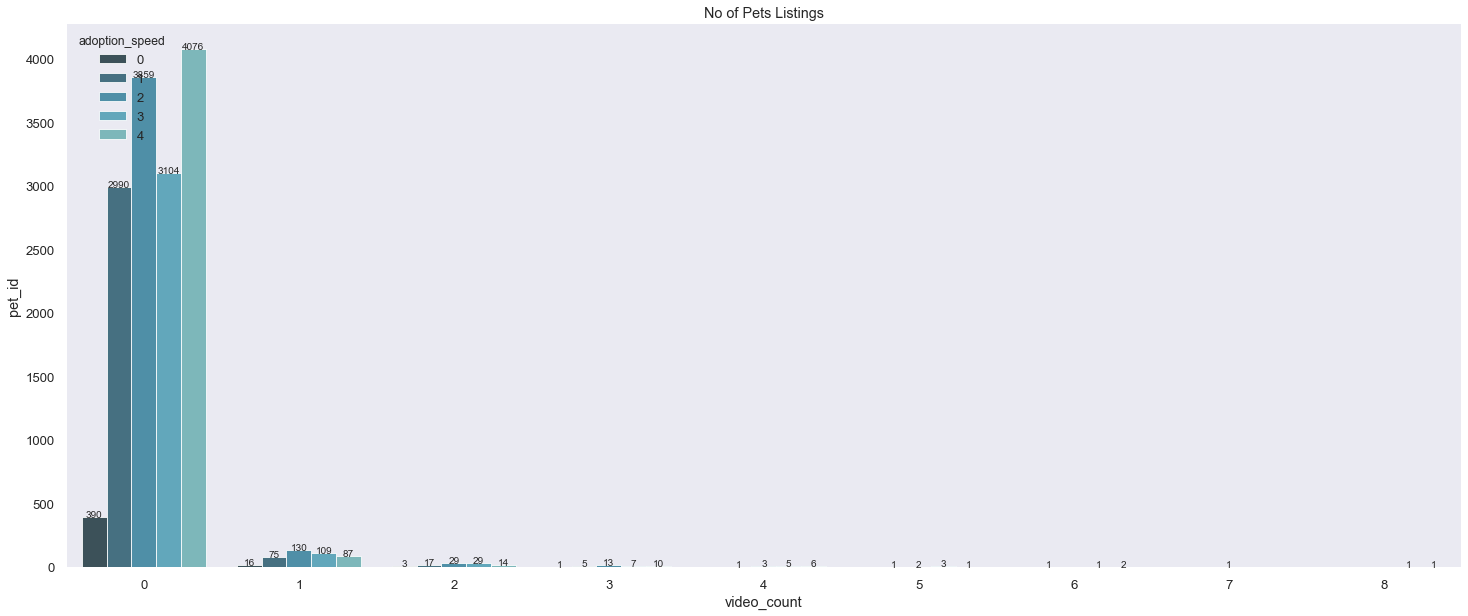

In [190]:
df_plot = pets[["video_count", "adoption_speed",
                "pet_id"]].groupby(["video_count", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "video_count", "pet_id", "adoption_speed", 
             "No of Pets Listings", figsize = (25,10))

### Photo Count

In [191]:
display(pd.DataFrame((pets.photo_count.value_counts(normalize=True)*100)))

photo_count
1.0   20.509571  
2.0   16.794504  
3.0   16.747816  
5.0   14.320016  
4.0   12.545855  
6.0   4.141933   
7.0   2.881345   
0.0   2.274395   
8.0   2.094311   
9.0   1.540719   
10.0  1.267258   
11.0  1.227239   
12.0  0.646969   
13.0  0.573601   
14.0  0.520243   
15.0  0.333489   
16.0  0.260121   
17.0  0.180084   
20.0  0.166744   
19.0  0.133396   
30.0  0.126726   
18.0  0.120056   
21.0  0.106716   
24.0  0.100047   
23.0  0.080037   
26.0  0.066698   
22.0  0.060028   
25.0  0.053358   
28.0  0.046688   
27.0  0.040019   
29.0  0.040019

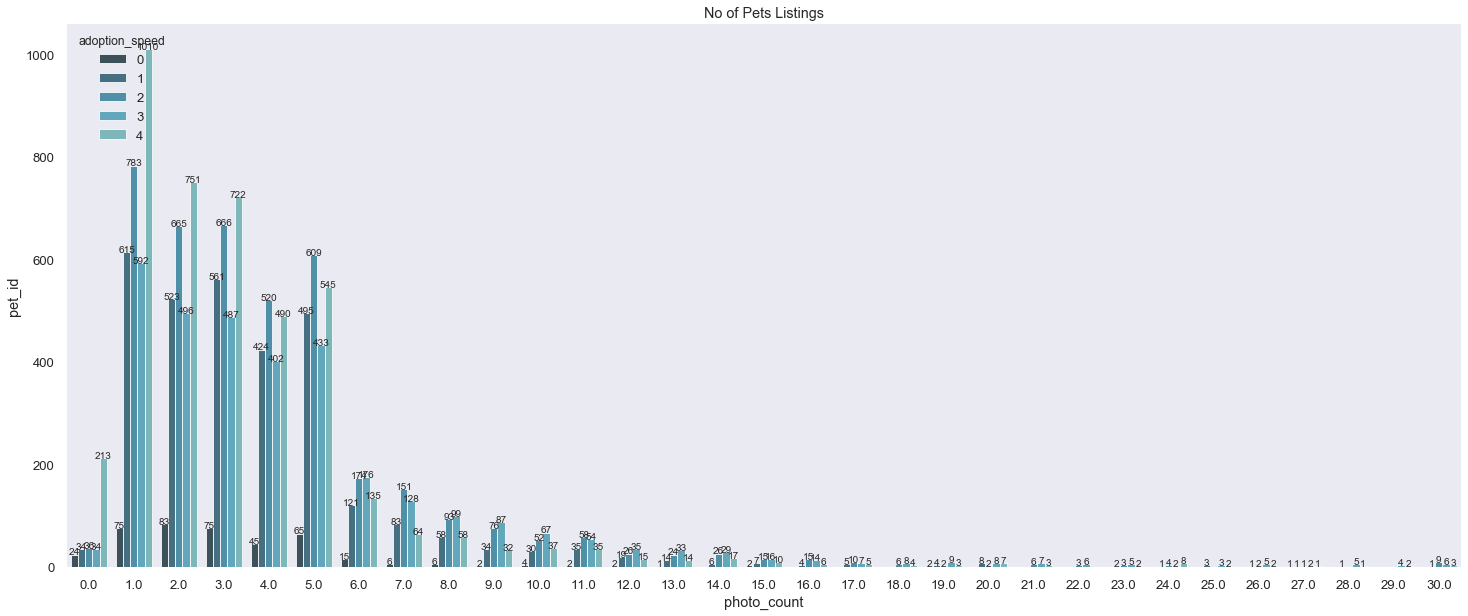

In [192]:
df_plot = pets[["photo_count", "adoption_speed",
                "pet_id"]].groupby(["photo_count", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "photo_count", "pet_id", "adoption_speed", 
             "No of Pets Listings", figsize = (25,10))

### Description

Note:  Google NLP API was used for the sentiment analysis. 

* Score corresponds to the overall emotional leaning of the description. 
    - 0.25 to 1 is positive
    - -0.25 to 0.25 is neutral
    - -1 to -0.25 is negative
* Magnitude indicates the overall strength of emotion (positive or negative). Longer text blocks may have higher magnitude.

Below is the example of sentiment analysis using description of pet_id a83d95ead.

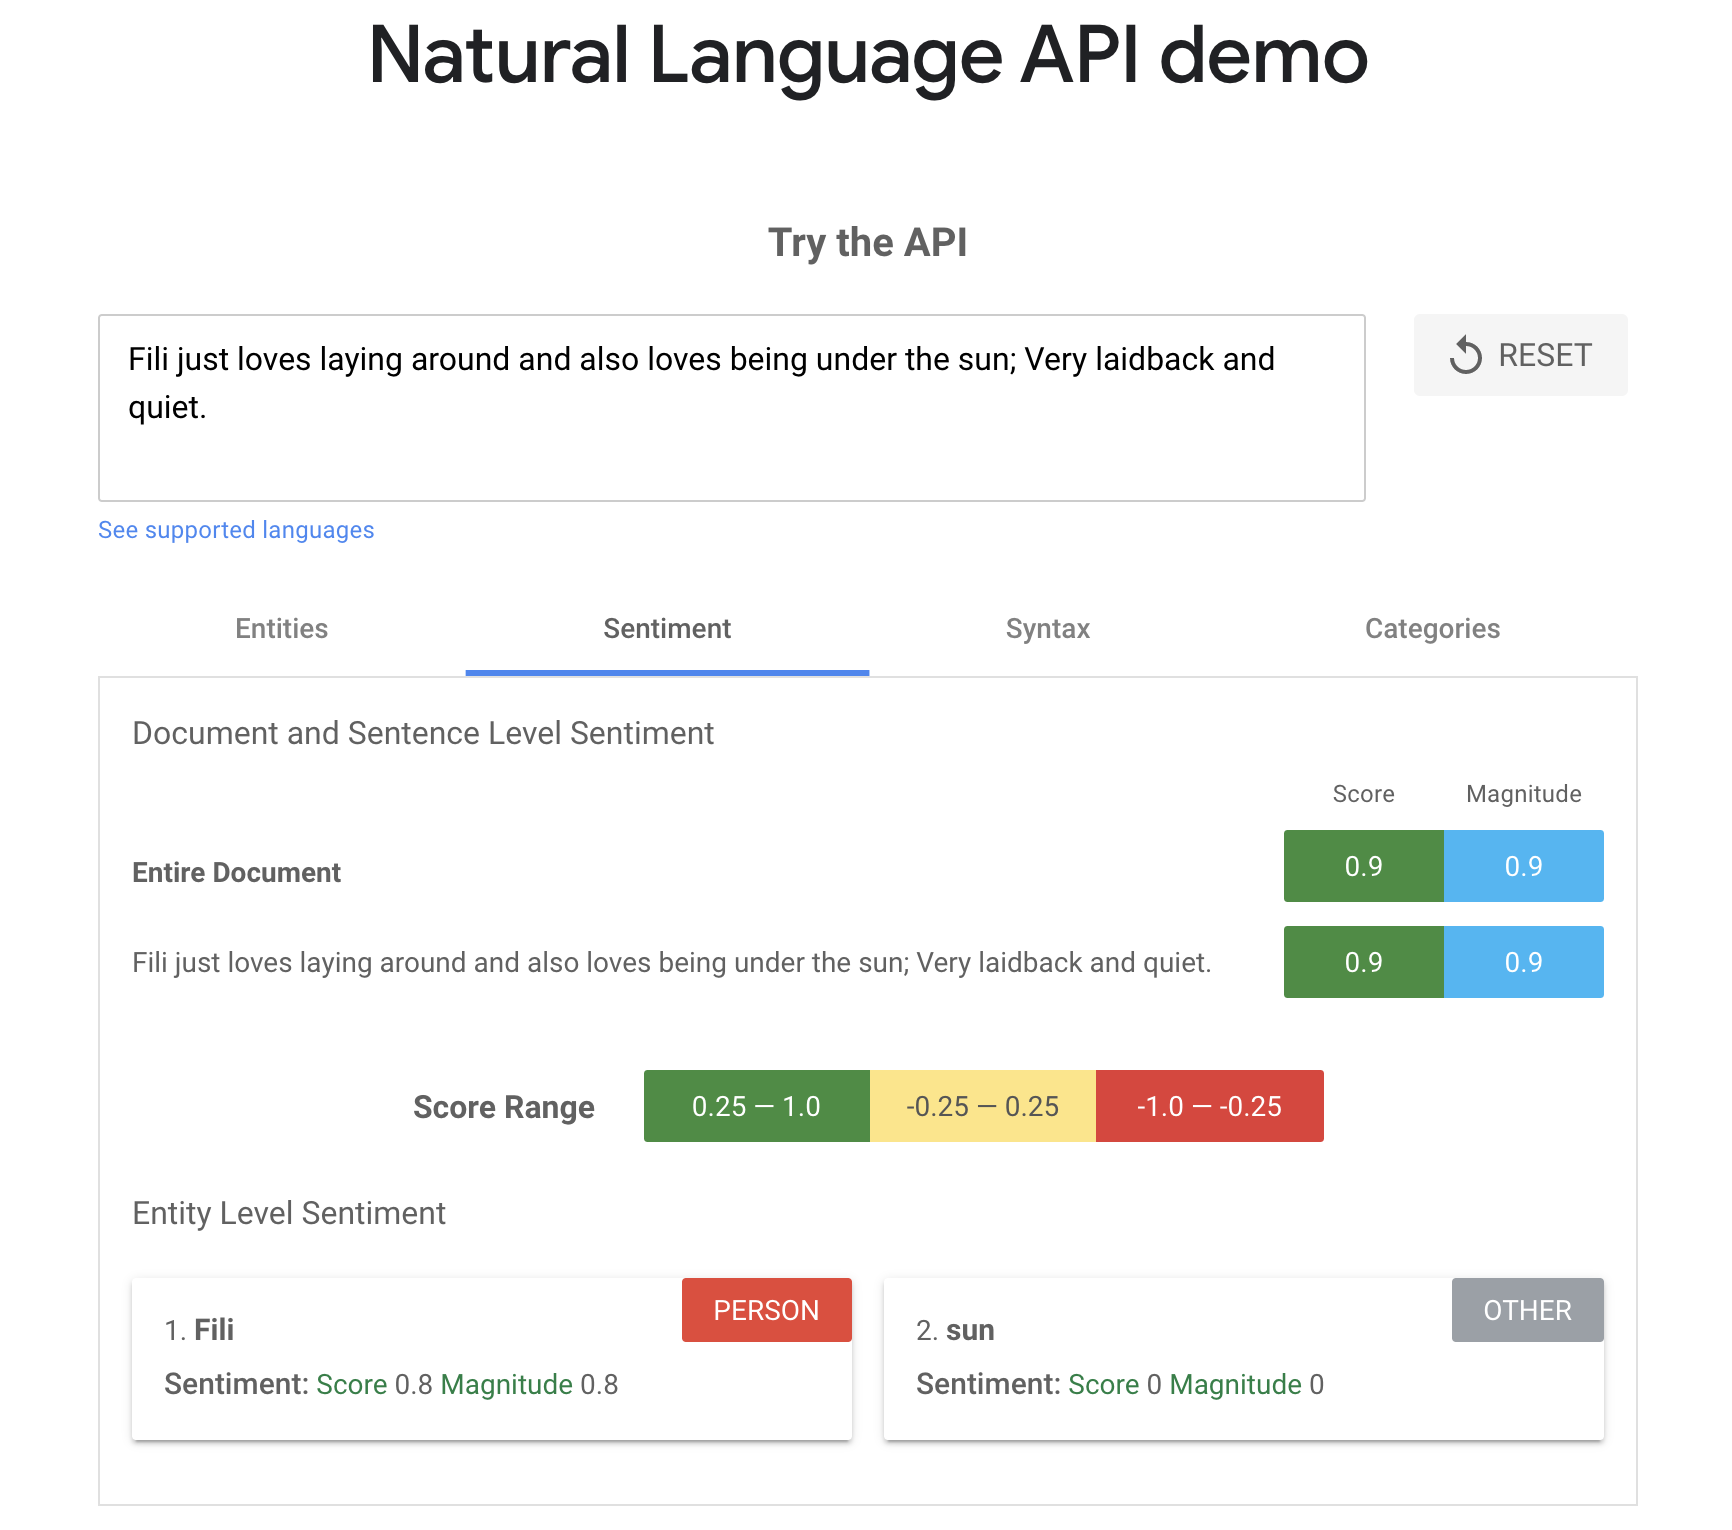

In [193]:
pre.get_image("dataset/", "fili.png")

In [194]:
pets.query("desc_score >= 0.25")[[
    "pet_id", "description", "desc_score", "adoption_speed"
]].sort_values("desc_score", ascending=False)

pet_id  \
14992  a83d95ead   
2878   082b9a2de   
12216  133234595   
12211  bcd23d8c3   
7925   be4275440   
...          ...   
9353   5fc6599fc   
9358   41ce762ce   
2307   8581566cb   
9370   a868df43f   
0      86e1089a3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           description  \
14992  Fili just loves laying around and also loves being under the sun; Very laidback and quiet.                                                                                                                                                                                                                                                                                                                                                                                                                                        
2878   Indoor and litter trained kitten with great personalities; cute, cuddly, cheeky and playful.                                                                                                                                                                                                                                                                                                                                                                                                                                      
12216  Saw this pet near my house.Very cute puppies.Not sure what breed but need some good people to adopt them                                                                                                                                                                                                                                                                                                                                                                                                                          
12211  cheerful, playful, hyper active, litter trained, and adorable,                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
7925   She is healthy and very beautiful and when she was 3 weeks years old I found her without her mother                                                                                                                                                                                                                                                                                                                                                                                                                               
...                                                                                                    ...                                                                                                                                                                                                                                                                                                                                                                                                                               
9353   She's so active. So playful and need new house. Currently I got 5 cats to look after. So I have to give away

In [195]:
dupe_desc = pets[pets.duplicated(["description", "quantity"], keep=False)]

dupe_desc[dupe_desc.description.isna() == False][[
    "pet_id", "age", "quantity", "description", "adoption_speed"]].sort_values("description").query("description ! = 'For Adoption'").query(
    "description ! = 'Dog 4 Adoption'").query(
        "description ! = 'Open for adoption!!!'").query("description ! = '-'")

pet_id  age  quantity  \
8409   1ccd49ce2  24   1          
4520   7ddf00d90  24   1          
2418   f68a56b90  24   1          
11577  d69a1f2a1  3    1          
8587   fd7ae9b79  3    1          
...          ... ..   ..          
5432   79799da25  10   1          
5672   c37d5c957  6    1          
7072   68c69f5c1  7    1          
1182   972fba985  9    1          
8212   bd485150e  6    1          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description  \
8409   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
4520   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
2418   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
11577  - 3 months old. - Female. - Blue eyed, white with black pattern. - Still shy with humans, but very playful with other kittens. We are now at Segambut, near Publika. Please let us know if you're interested to give her a permanent loving home.                                                                                                                                                                                                                                                                                            
8587   - 3 months old. - Female. - Blue eyed, white with black pattern. - Still shy with humans, but very playful with other kittens. We are now at Segambut, near Publika. Please let us know if you're interested to give her a permanent loving home.                                                                                                                                                                                                                                                                                            
...                                                                                                                                                                                                                                                  ...                                                                                                                                               

## Pre-processing

In [356]:
df = pd.read_csv("pets.csv")
pets = df.copy()
pets.shape

(14993, 35)

### Target variable

In [68]:
display(pd.DataFrame((pets.adoption_speed.value_counts(normalize=True)*100)))

adoption_speed
4  27.993063     
2  26.925899     
3  21.736811     
1  20.609618     
0  2.734609

In [357]:
pets.adoption_speed = pets.adoption_speed.map(lambda x: 1 if x == 0 else x)
display(pd.DataFrame((pets.adoption_speed.value_counts(normalize=True)*100)))

adoption_speed
4  27.993063     
2  26.925899     
1  23.344227     
3  21.736811

### Categorical Features with Not Specified or Not Sure category

* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

In [358]:
#MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
display(pd.DataFrame((pets.maturity_size.value_counts(normalize=True)*100)))

maturity_size
2  68.732075    
1  22.643900    
3  8.403922     
4  0.220103

In [359]:
#FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
display(pd.DataFrame((pets.fur_length.value_counts(normalize=True)*100)))

fur_length
1  58.747415 
2  35.756686 
3  5.495898

In [360]:
#Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
display(pd.DataFrame((pets.vaccinated.value_counts(normalize=True)*100)))

vaccinated
2  48.202494 
1  39.338358 
3  12.459148

In [361]:
pets.vaccinated = pets.vaccinated.map(lambda x: 1 if x == 1 else 0)
display(pd.DataFrame((pets.vaccinated.value_counts(normalize=True)*100)))

vaccinated
0  60.661642 
1  39.338358

In [362]:
#Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
display(pd.DataFrame((pets.dewormed.value_counts(normalize=True)*100)))

dewormed
1  56.006136
2  32.114987
3  11.878877

In [363]:
pets.dewormed = pets.dewormed.map(lambda x: 1 if x == 1 else 0)
display(pd.DataFrame((pets.dewormed.value_counts(normalize=True)*100)))

dewormed
1  56.006136
0  43.993864

In [364]:
#Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
display(pd.DataFrame((pets.sterilized.value_counts(normalize=True)*100)))

sterilized
2  67.211365 
1  20.682985 
3  12.105649

In [365]:
pets.sterilized = pets.sterilized.map(lambda x: 1 if x == 1 else 0)
display(pd.DataFrame((pets.sterilized.value_counts(normalize=True)*100)))

sterilized
0  79.317015 
1  20.682985

In [366]:
#Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
display(pd.DataFrame((pets.health.value_counts(normalize=True)*100)))

health
1  96.565064
2  3.208164 
3  0.226772

In [367]:
print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 35)
New shape =  (14993, 35)


### Duplicates, zero and null values

In [368]:
#Remove 0 age for adoption speed rate 3 & 4
no_age = pets.query("age == 0").query("adoption_speed > 2").index
pets = pre.drop_rows(pets, no_age)

#Remove those with no description
no_desc = pets[pets.description.isna() == True].index
pets = pre.drop_rows(pets, no_desc)
no_desc_analysis = pets[pets.desc_score.isna() == True].index
pets = pre.drop_rows(pets, no_desc_analysis)

pets.reset_index(drop = True, inplace=True)

print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 35)
New shape =  (14373, 35)


In [369]:
pets.sort_values("age",ascending=False)

adoption_speed     pet_id  type                              name  age  \
10730  4               50682d0f1  1     FiFi                              255   
4939   4               5971c2462  1     Happy-FIFI                        255   
12847  4               e01f077a7  1     Enzo                              238   
12324  4               36d7fc2c5  1     Snow                              212   
10646  3               e77f9e778  2     Three Kittens                     212   
...   ..                     ... ..               ...                     ...   
7462   1               a486e2ab6  1     Puppies                           0     
1313   2               85114144b  2     Oren-oren (Both Male)             0     
1267   2               eea15297e  1     Cute Puppy                        0     
1253   1               896bb46bd  1     Unknown                           0     
3078   1               4c6048341  2     Chubby Kittens Need Caring Home.  0     

       breed1           breed1_desc  breed2          breed2_desc  gender  \
10730  307     mixed_breed           0       NaN                  1        
4939   307     mixed_breed           0       NaN                  1        
12847  307     mixed_breed           0       NaN                  1        
12324  307     mixed_breed           0       NaN                  2        
10646  266     domestic_short_hair   266     domestic_short_hair  3        
...    ...                     ...   ...                     ... ..        
7462   307     mixed_breed           0       NaN                  3        
1313   266     domestic_short_hair   0       NaN                  1        
1267   307     mixed_breed           0       NaN                  1        
1253   218     terrier               218     terrier              1        
3078   265     domestic_medium_hair  0       NaN                  3        

       color1 color1_desc  color2 color2_desc  color3 color3_desc  \
10730  2       brown       7       white       0       NaN          
4939   2       brown       7       white       0       NaN          
12847  7       white       0       NaN         0       NaN          
12324  7       white       0       NaN         0       NaN          
10646  1       black       5       cream       7       white        
...   ..         ...      ..         ...      ..         ...        
7462   1       black       6       gray        0       NaN          
1313   4       yellow      5       cream       0       NaN          
1267   2       brown       0       NaN         0       NaN          
1253   5       cream       0       NaN         0       NaN          
3078   1       black       2       brown       7       white        

       maturity_size  fur_length  vaccinated  dewormed  sterilized  health  \
10730  2              2           0           0         0           1        
4939   2              2           0           0         0           1        
12847  2              1           1           1         1           1        
12324  2              1           0           0         0           1        
10646  1              1           1           1         0           1        
...   ..             ..          ..          ..        ..          ..        
7462   1              2           0           0         0           1        
1313   2              1           0           0         0           1        
1267   2              2           0           0         0           1        
1253   2              3           0           0         0           1        
3078   1              2           0           0         0           1        

       quantity  fee  state    state_desc                        rescuer_id  \
10730  1         0    41330  perak         94fdeec413a441bca0de9e9887edcc70   
4939   1         0    41330  perak         94fdeec413a441bca0de9e9887edcc70   
12847  1         0    41327  pulau_pinang  b39c5db7a450d0f3437ada1df3554db6   
12324  1         0    41401  kuala_lump

In [370]:
pets = pre.drop_rows(pets, list(pets.query("pet_id == '50682d0f1'").index))

In [371]:
pets.sort_values("age",ascending=False)

adoption_speed     pet_id  type                              name  age  \
4939   4               5971c2462  1     Happy-FIFI                        255   
12847  4               e01f077a7  1     Enzo                              238   
3829   3               53923463d  2     Kitkat                            212   
12324  4               36d7fc2c5  1     Snow                              212   
10646  3               e77f9e778  2     Three Kittens                     212   
...   ..                     ... ..               ...                     ...   
7462   1               a486e2ab6  1     Puppies                           0     
1313   2               85114144b  2     Oren-oren (Both Male)             0     
1267   2               eea15297e  1     Cute Puppy                        0     
1253   1               896bb46bd  1     Unknown                           0     
3078   1               4c6048341  2     Chubby Kittens Need Caring Home.  0     

       breed1           breed1_desc  breed2          breed2_desc  gender  \
4939   307     mixed_breed           0       NaN                  1        
12847  307     mixed_breed           0       NaN                  1        
3829   266     domestic_short_hair   0       NaN                  2        
12324  307     mixed_breed           0       NaN                  2        
10646  266     domestic_short_hair   266     domestic_short_hair  3        
...    ...                     ...   ...                     ... ..        
7462   307     mixed_breed           0       NaN                  3        
1313   266     domestic_short_hair   0       NaN                  1        
1267   307     mixed_breed           0       NaN                  1        
1253   218     terrier               218     terrier              1        
3078   265     domestic_medium_hair  0       NaN                  3        

       color1 color1_desc  color2 color2_desc  color3 color3_desc  \
4939   2       brown       7       white       0       NaN          
12847  7       white       0       NaN         0       NaN          
3829   1       black       0       NaN         0       NaN          
12324  7       white       0       NaN         0       NaN          
10646  1       black       5       cream       7       white        
...   ..         ...      ..         ...      ..         ...        
7462   1       black       6       gray        0       NaN          
1313   4       yellow      5       cream       0       NaN          
1267   2       brown       0       NaN         0       NaN          
1253   5       cream       0       NaN         0       NaN          
3078   1       black       2       brown       7       white        

       maturity_size  fur_length  vaccinated  dewormed  sterilized  health  \
4939   2              2           0           0         0           1        
12847  2              1           1           1         1           1        
3829   2              1           1           1         0           1        
12324  2              1           0           0         0           1        
10646  1              1           1           1         0           1        
...   ..             ..          ..          ..        ..          ..        
7462   1              2           0           0         0           1        
1313   2              1           0           0         0           1        
1267   2              2           0           0         0           1        
1253   2              3           0           0         0           1        
3078   1              2           0           0         0           1        

       quantity  fee  state    state_desc                        rescuer_id  \
4939   1         0    41330  perak         94fdeec413a441bca0de9e9887edcc70   
12847  1         0    41327  pulau_pinang  b39c5db7a450d0f3437ada1df3554db6   
3829   1         0    41330  perak         60689896aa0edff3a4f05b890bdafd26   
12324  1         0    41401  kuala_lump

### Other Categorical features

As there are 307 possible values for breeds and they do not have a natural ordering, I will bin and order the breeds based on how fast they are adopted.

Since Mixed Breed and Domestic are the most common values, I will categorised breed into these 3:
1. Pure Bred Non-Domestic
2. Pure Bred Domestic 
3. Mixed Bred

In [373]:
pets = pre.bin_breed(pets)
print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 35)
New shape =  (14372, 37)


In [375]:
pets[["breed_bin", "breed1_desc", "breed2_desc"]].sample(5)

breed_bin           breed1_desc  breed2_desc
6845   3          mixed_breed           NaN        
9623   3          mixed_breed           mixed_breed
5871   2          domestic_short_hair   NaN        
11252  3          mixed_breed           NaN        
11027  2          domestic_medium_hair  NaN

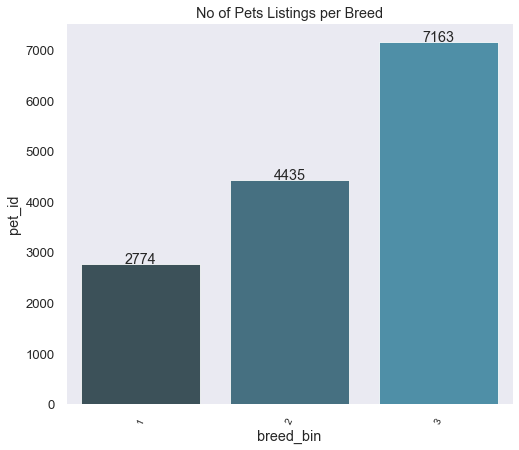

In [376]:
df_plot = pets[["breed_bin",
                "pet_id"]].groupby("breed_bin").count().sort_values(
                    "pet_id", ascending=False).iloc[:10, ].reset_index()
pre.plot_bar(df_plot, "breed_bin", "pet_id",
             "No of Pets Listings per Breed", rotate = True)

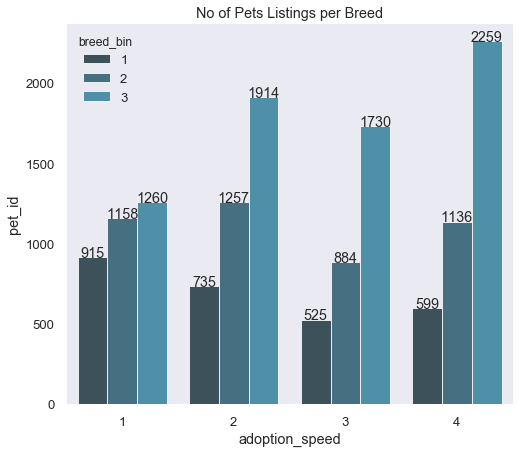

In [377]:
df_plot = pets[["breed_bin", "adoption_speed", "pet_id"]].groupby(["breed_bin", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot,"adoption_speed", "pet_id", "breed_bin", "No of Pets Listings per Breed", rotate = False)

In [378]:
check = pd.merge(pets[["breed_bin", "adoption_speed", "pet_id"]].groupby([
    "breed_bin", "adoption_speed"
]).count().sort_values(["breed_bin", "adoption_speed"]).reset_index(),
                 pets[["breed_bin", "pet_id"
                            ]].groupby(["breed_bin"]).count().reset_index(),
                 on="breed_bin")
check["ratio"] = check["pet_id_x"] / check["pet_id_y"]

print("AdoptionSpeed 0-2")
display(check[["breed_bin", "adoption_speed", "ratio"
               ]].query("adoption_speed < 3").groupby("breed_bin").sum()[[
                   "ratio"
               ]].sort_values("ratio", ascending=False))

print("Adoption Speed 3&4")
display(check[["breed_bin", "adoption_speed", "ratio"
               ]].query("adoption_speed > 2").groupby("breed_bin").sum()[[
                   "ratio"
               ]].sort_values("ratio"))

AdoptionSpeed 0-2


ratio
breed_bin          
1          0.594809
2          0.544532
3          0.443110

Adoption Speed 3&4


ratio
breed_bin          
1          0.405191
2          0.455468
3          0.556890

Based on the above tables, breed 1 has the highest percentage of listings adopted within a month and also has the lowest for more than a month.

In [379]:
pets.type  = pets.type.map(lambda x: "dog" if x == 1 else "cat")
display(pd.DataFrame((pets.type.value_counts(normalize=True)*100)))

type
dog  56.046479
cat  43.953521

In [384]:
#Convert age into categorical
pets.age = pets.age.map(lambda x: x/12)
display(pd.DataFrame((pets.age.value_counts(normalize=True)*100)).head(10))

age
0.166667  23.601447
0.083333  15.404954
0.250000  13.310604
0.333333  7.382410 
1.000000  6.255218 
2.000000  4.369608 
0.416667  3.993877 
0.500000  3.666852 
3.000000  2.873643 
0.666667  2.073476

In [385]:
pets = pre.color_dummies(pets)
print("New shape = ", pets.shape)

New shape =  (14372, 43)


In [386]:
pets = pd.get_dummies(pets, prefix="state", columns = ["state_desc"], drop_first = True, dtype = "float64")
print("New shape = ", pets.shape)

New shape =  (14372, 55)


In [387]:
state_details = pd.read_csv("dataset/petfinder-adoption-prediction/Malaysian_States.csv")
pets = pd.merge(pets, state_details, left_on= "state", right_on="StateID")
pets = pre.drop_columns(pets, ["StateID", "StateName"])
pets.columns = pets.columns.map(lambda x: x.lower())
print("Original shape = ", df.shape)
print("New shape = ", pets.shape)
pets.head()

Original shape =  (14993, 35)
New shape =  (14372, 59)


adoption_speed     pet_id type    name       age  breed1  \
0  2               86e1089a3  cat  Nibble  0.250000  299      
1  3               3422e4906  dog  Brisco  0.083333  307      
2  2               850a43f90  dog  Hunter  0.083333  307      
3  2               d24c30b4b  cat  NaN     0.250000  266      
4  1               1caa6fcdb  cat  BULAT   1.000000  264      

           breed1_desc  breed2         breed2_desc  gender  color1  \
0  tabby                0       NaN                 1       1        
1  mixed_breed          0       NaN                 1       2        
2  mixed_breed          0       NaN                 1       1        
3  domestic_short_hair  0       NaN                 2       5        
4  domestic_long_hair   264     domestic_long_hair  1       1        

  color1_desc  color2 color2_desc  color3 color3_desc  maturity_size  \
0  black       7       white       0       NaN         1               
1  brown       7       white       0       NaN         2               
2  black       0       NaN         0       NaN         2               
3  cream       6       gray        0       NaN         2               
4  black       0       NaN         0       NaN         2               

   fur_length  vaccinated  dewormed  sterilized  health  quantity  fee  state  \
0  1           0           0         0           1       1         100  41326   
1  2           1           1         0           1       1         0    41326   
2  1           0           0         0           1       1         0    41326   
3  1           0           0         0           1       1         0    41326   
4  3           0           0         0           1       1         300  41326   

                         rescuer_id  video_count  photo_count  \
0  8480853f516546f6cf33aa88cd76c379  0            1.0           
1  fa90fa5b1ee11c86938398b60abc32cb  0            7.0           
2  95481e953f8aed9ec3d16fc4509537e8  0            3.0           
3  22fe332bf9c924d4718005891c63fbed  0            2.0           
4  1e0b5a458b5b77f5af581d57ebf570b3  0            3.0           

          filename  \
0  86e1089a3-1.jpg   
1  3422e4906-3.jpg   
2  850a43f90-1.jpg   
3  d24c30b4b-2.jpg   
4  1caa6fcdb-1.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                        description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.                                            
1  Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.          
2  This handsome yet cute boy is up for adoption. He is the most playful pal we've seen in our puppies. He loves to nibble on shoelaces , Chase you at such a young age. Imagine what a cute brat he will be when he grows. We are looking for a loving home for Hunter , one that will take care of him and give him the love that he needs. Please call urgently if you would like to adopt this cutie.             
3  This is a stray kitten that came to my house. Have been feeding it, but cannot keep it.                                         

In [388]:
col_cat = ["type", "gender"]
pets = pd.get_dummies(pets, columns = col_cat, drop_first = True, dtype = "float64")
print("New shape = ",  pets.shape)

New shape =  (14372, 60)


In [389]:
pets.rename(mapper={
    "gender_2": "gender_female",
    "gender_3": "gender_mixed",
    "population": "state_population",
    "area": "state_area",
    "population density": "state_density",
    "gdp_per_capita_2017": "state_gdp_per_capita"
},
            axis=1,
            inplace=True)

print("New shape = ", pets.shape)

New shape =  (14372, 60)


In [390]:
for col in list(pets.columns):
    if pets[col].isna().sum()>0:
        print(col, pets[col].isna().sum(), "null values")

name 1211 null values
breed1_desc 5 null values
breed2_desc 10312 null values
color2_desc 4331 null values
color3_desc 10229 null values
filename 321 null values


In [391]:
set(pets.columns)

{'adoption_speed',
 'age',
 'breed1',
 'breed1_desc',
 'breed2',
 'breed2_desc',
 'breed_bin',
 'check',
 'color1',
 'color1_desc',
 'color2',
 'color2_desc',
 'color3',
 'color3_desc',
 'color_brown',
 'color_cream',
 'color_golden',
 'color_gray',
 'color_white',
 'color_yellow',
 'desc_magnitude',
 'desc_score',
 'desc_sentences_score_avg',
 'desc_sentences_score_sum',
 'description',
 'dewormed',
 'fee',
 'filename',
 'fur_length',
 'gender_female',
 'gender_mixed',
 'health',
 'maturity_size',
 'name',
 'pet_id',
 'photo_count',
 'quantity',
 'rescuer_id',
 'state',
 'state_area',
 'state_density',
 'state_gdp_per_capita',
 'state_kedah',
 'state_kelantan',
 'state_kuala_lumpur',
 'state_labuan',
 'state_melaka',
 'state_negeri_sembilan',
 'state_pahang',
 'state_perak',
 'state_population',
 'state_pulau_pinang',
 'state_sabah',
 'state_sarawak',
 'state_selangor',
 'state_terengganu',
 'sterilized',
 'type_dog',
 'vaccinated',
 'video_count'}

In [392]:
col_excl = [
    "name", "state", "rescuer_id", "breed1", "breed1_desc", "breed2",
    "breed2_desc", "color1", "color1_desc", "color2", "color2_desc", "color3",
    "color3_desc", "desc_sentences_score_avg", "check"
]
pets = pre.drop_columns(pets, col_excl)

In [393]:
pets.to_csv("pets_model_final.csv", index=False)

In [394]:
pets.columns

Index(['adoption_speed', 'pet_id', 'age', 'maturity_size', 'fur_length',
       'vaccinated', 'dewormed', 'sterilized', 'health', 'quantity', 'fee',
       'video_count', 'photo_count', 'filename', 'description', 'desc_score',
       'desc_magnitude', 'desc_sentences_score_sum', 'breed_bin',
       'color_brown', 'color_cream', 'color_golden', 'color_gray',
       'color_white', 'color_yellow', 'state_kedah', 'state_kelantan',
       'state_kuala_lumpur', 'state_labuan', 'state_melaka',
       'state_negeri_sembilan', 'state_pahang', 'state_perak',
       'state_pulau_pinang', 'state_sabah', 'state_sarawak', 'state_selangor',
       'state_terengganu', 'state_population', 'state_area', 'state_density',
       'state_gdp_per_capita', 'type_dog', 'gender_female', 'gender_mixed'],
      dtype='object')

### Interactions

In [395]:
pets = pd.read_csv("pets_model_final.csv")
pets.shape

(14372, 45)

In [396]:
interaction_health = ["vaccinated", "dewormed", "sterilized", "health"]
interaction_sentiment = ["desc_score", "desc_magnitude", "desc_sentences_score_sum"]
interaction_state = ["state_population", "state_area", "state_density", "state_gdp_per_capita"]

X_interaction_health = pre.get_interaction(pets, interaction_health, 2)
X_interaction_sentiment = pre.get_interaction(pets, interaction_sentiment, 2)
X_interaction_state = pre.get_interaction(pets, interaction_state, 2)

In [397]:
for col in list(X_interaction_health.columns):
    X_interaction_health[col] = X_interaction_health[col].astype("int64")
    
X_interaction_health.info(), X_interaction_sentiment.info(), X_interaction_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14372 entries, 0 to 14371
Data columns (total 10 columns):
vaccinated               14372 non-null int64
dewormed                 14372 non-null int64
sterilized               14372 non-null int64
health                   14372 non-null int64
vaccinated_dewormed      14372 non-null int64
vaccinated_sterilized    14372 non-null int64
vaccinated_health        14372 non-null int64
dewormed_sterilized      14372 non-null int64
dewormed_health          14372 non-null int64
sterilized_health        14372 non-null int64
dtypes: int64(10)
memory usage: 1.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14372 entries, 0 to 14371
Data columns (total 6 columns):
desc_score                                 14372 non-null float64
desc_magnitude                             14372 non-null float64
desc_sentences_score_sum                   14372 non-null float64
desc_score_desc_magnitude                  14372 non-null float64
desc_score_desc_sent

(None, None, None)

In [398]:
pets_interactions = pre.drop_columns(
    pets, interaction_health + interaction_sentiment + interaction_state)

pets_model = pd.concat(
    [pets_interactions, X_interaction_health, X_interaction_state, X_interaction_sentiment], axis=1)

pets_model.head(1)

adoption_speed     pet_id   age  maturity_size  fur_length  quantity  fee  \
0  2               86e1089a3  0.25  1              1           1         100   

   video_count  photo_count         filename  \
0  0            1.0          86e1089a3-1.jpg   

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   

   breed_bin  color_brown  color_cream  color_golden  color_gray  color_white  \
0  1          0.0          0.0          0.0           0.0         1.0           

   color_yellow  state_kedah  state_kelantan  state_kuala_lumpur  \
0  0.0           0.0          0.0             0.0                  

   state_labuan  state_melaka  state_negeri_sembilan  state_pahang  \
0  0.0           0.0           0.0                    0.0            

   state_perak  state_pulau_pinang  state_sabah  state_sarawak  \
0  0.0          0.0                 0.0          0.0             

   state_selangor  state_terengganu  type_dog  gender_female  gender_mixed  \
0  1.0             0.0               0.0       0.0            0.0            

   vaccinated  dewormed  sterilized  health  vaccinated_dewormed  \
0  0           0         0           1       0                     

   vaccinated_sterilized  vaccinated_health  dewormed_sterilized  \
0  0                      0                  0                     

   dewormed_health  sterilized_health  state_population  state_area  \
0  0                0                  5411324.0         8104.0       

   state_density  state_gdp_per_capita  state_population_state_area  \
0  668.0          48091.0               4.385337e+10                  

   state_population_state_density  state_population_state_gdp_per_capita  \
0  3.614764e+09                    2.602360e+11                            

   state_area_state_density  state_area_state_gdp_per_capita  \
0  5413472.0                 389729464.0                       

   state_density_state_gdp_per_capita  desc_score  desc_magnitude  \
0  32124788.0                          0.3         2.4              

   desc_sentences_score_sum  desc_score_desc_magnitude  \
0  1.8                       0.72                        

   desc_score_desc_sentences_score_sum  \
0  0.54                                  

   desc_magnitude_desc_sentences_score_sum  
0  4.32

In [400]:
pets_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14372 entries, 0 to 14371
Data columns (total 60 columns):
adoption_speed                             14372 non-null int64
pet_id                                     14372 non-null object
age                                        14372 non-null float64
maturity_size                              14372 non-null int64
fur_length                                 14372 non-null int64
quantity                                   14372 non-null int64
fee                                        14372 non-null int64
video_count                                14372 non-null int64
photo_count                                14372 non-null float64
filename                                   14051 non-null object
description                                14372 non-null object
breed_bin                                  14372 non-null int64
color_brown                                14372 non-null float64
color_cream                                14372 n

In [401]:
pets_model.to_csv("pets_interactions_final.csv", index=False)

# Multi-class Problem

In [521]:
pets = pd.read_csv("pets_interactions_final.csv")
pets.shape

(14372, 60)

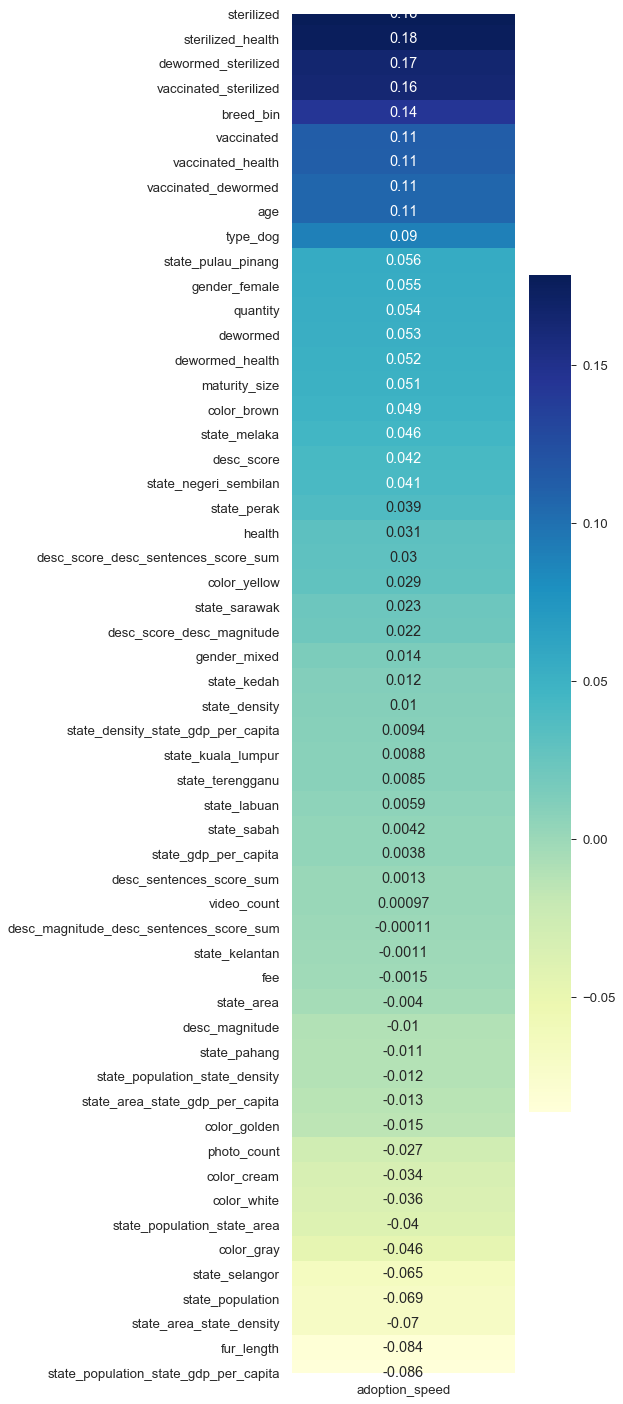

In [405]:
plt.figure(figsize=(5, 25))
sns.heatmap(data = pets.corr()[["adoption_speed"]].iloc[1:,:].sort_values("adoption_speed", ascending=False), annot=True, cmap="YlGnBu");

In [524]:
target = ["adoption_speed"]
to_scale = [
    "age","video_count", "photo_count", "quantity", "fee", "state_population",
    "state_area", "state_density", "state_gdp_per_capita",
    "state_population_state_area", "state_population_state_density",
    "state_population_state_gdp_per_capita", "state_area_state_density",
    "state_area_state_gdp_per_capita", "state_density_state_gdp_per_capita",
    "desc_score", "desc_magnitude", "desc_sentences_score_sum",
    "desc_score_desc_magnitude", "desc_score_desc_sentences_score_sum",
    "desc_magnitude_desc_sentences_score_sum"
]
to_exclude = ["filename", "pet_id", "description"]

cat_feat = sorted(
    list(set(list(pets.columns)) - set(target + to_scale + to_exclude)))

#This is to check whether cat_feat has only categorical columns
display(list(cat_feat))
set(pets.columns) - set(cat_feat + to_scale + to_exclude + target)

['breed_bin',
 'color_brown',
 'color_cream',
 'color_golden',
 'color_gray',
 'color_white',
 'color_yellow',
 'dewormed',
 'dewormed_health',
 'dewormed_sterilized',
 'fur_length',
 'gender_female',
 'gender_mixed',
 'health',
 'maturity_size',
 'state_kedah',
 'state_kelantan',
 'state_kuala_lumpur',
 'state_labuan',
 'state_melaka',
 'state_negeri_sembilan',
 'state_pahang',
 'state_perak',
 'state_pulau_pinang',
 'state_sabah',
 'state_sarawak',
 'state_selangor',
 'state_terengganu',
 'sterilized',
 'sterilized_health',
 'type_dog',
 'vaccinated',
 'vaccinated_dewormed',
 'vaccinated_health',
 'vaccinated_sterilized']

set()

In [525]:
ordinal = []
for i in cat_feat:
    if pets[i].nunique() > 2:
        ordinal.append(i)
print(ordinal)

['breed_bin', 'dewormed_health', 'fur_length', 'health', 'maturity_size', 'sterilized_health', 'vaccinated_health']


### Baseline Model

In [526]:
y = pets[target]
X = pre.drop_columns(pets, to_exclude+target)
print(len(X.columns))
#Convert ordinal variables into dummies     
X = pd.get_dummies(X, columns = ordinal, drop_first=True, dtype="float64")
X.columns

56


Index(['age', 'quantity', 'fee', 'video_count', 'photo_count', 'color_brown',
       'color_cream', 'color_golden', 'color_gray', 'color_white',
       'color_yellow', 'state_kedah', 'state_kelantan', 'state_kuala_lumpur',
       'state_labuan', 'state_melaka', 'state_negeri_sembilan', 'state_pahang',
       'state_perak', 'state_pulau_pinang', 'state_sabah', 'state_sarawak',
       'state_selangor', 'state_terengganu', 'type_dog', 'gender_female',
       'gender_mixed', 'vaccinated', 'dewormed', 'sterilized',
       'vaccinated_dewormed', 'vaccinated_sterilized', 'dewormed_sterilized',
       'state_population', 'state_area', 'state_density',
       'state_gdp_per_capita', 'state_population_state_area',
       'state_population_state_density',
       'state_population_state_gdp_per_capita', 'state_area_state_density',
       'state_area_state_gdp_per_capita', 'state_density_state_gdp_per_capita',
       'desc_score', 'desc_magnitude', 'desc_sentences_score_sum',
       'desc_score_des

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

---------------------------------------------------------------------
Accuracy score:  35.0 %
Quadratic Cohen-Kappa score:  25.0 %
---------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           1       0.33      0.48      0.39       652
           2       0.34      0.17      0.23       793
           3       0.27      0.27      0.27       614
           4       0.43      0.49      0.46       816

    accuracy                           0.35      2875
   macro avg       0.34      0.35      0.34      2875
weighted avg       0.35      0.35      0.34      2875

---------------------------------------------------------------------
Confusion Matrix: 



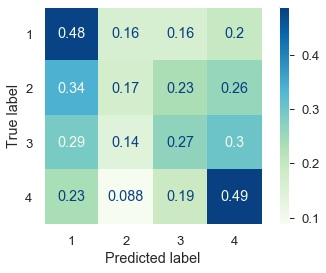

In [527]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train_scaled, X_test_scaled = func.minmax_scaler(X_train, X_test, to_scale)
baseline_model = LogisticRegression(class_weight="balanced", random_state=42)
display(baseline_model)
baseline_model.fit(X_train_scaled, y_train)
func.evaluate(baseline_model, X_train_scaled, X_test_scaled, y_train, y_test)
pickle.dump(baseline_model, open("logreg_base.pkl", "wb"))
# baseline_model= pickle.load(open("logreg_base.pkl", "rb"))

### Evaluate Various Classifiers

In [528]:
y = pets[target]
X = pre.drop_columns(pets, to_exclude+target)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train_scaled, X_test_scaled = func.minmax_scaler(X_train, X_test, to_scale)
display(X_train_scaled.head(), y_train.head())

age  video_count  photo_count  quantity  fee  state_population  \
9236   0.011765  0.0          0.066667     0.000000  0.0  0.289501           
13767  0.094118  0.0          0.166667     0.000000  0.0  0.591087           
14319  0.058824  0.0          0.033333     0.105263  0.0  0.569797           
10218  0.007843  0.0          0.166667     0.105263  0.0  0.289501           
6088   0.007843  0.0          0.166667     0.000000  0.0  1.000000           

       state_area  state_density  state_gdp_per_capita  \
9236   0.001222    1.000000       1.000000               
13767  0.153740    0.022315       0.212518               
14319  0.591352    0.003445       0.106275               
10218  0.001222    1.000000       1.000000               
6088   0.064434    0.097199       0.353000               

       state_population_state_area  state_population_state_density  \
9236   0.001287                     1.000000                         
13767  0.206223                     0.045830                         
14319  0.762791                     0.007840                         
10218  0.001287                     1.000000                         
6088   0.145588                     0.328933                         

       state_population_state_gdp_per_capita  state_area_state_density  \
9236   0.689341                               0.289377                   
13767  0.414291                               0.589694                   
14319  0.271754                               0.564399                   
10218  0.689341                               0.289377                   
6088   1.000000                               1.000000                   

       state_area_state_gdp_per_capita  state_density_state_gdp_per_capita  \
9236   0.003432                         1.000000                             
13767  0.106656                         0.006495                             
14319  0.286918                         0.000094                             
10218  0.003432                         1.000000                             
6088   0.062570                         0.041892                             

       desc_score  desc_magnitude  desc_sentences_score_sum  \
9236   0.500000    0.053125        0.250000                   
13767  0.500000    0.053125        0.245614                   
14319  0.944444    0.025000        0.276316                   
10218  0.666667    0.043750        0.293860                   
6088   0.500000    0.053125        0.250000                   

       desc_score_desc_magnitude  desc_score_desc_sentences_score_sum  \
9236   0.171975                   0.005487                              
13767  0.171975                   0.005487                              
14319  0.230209                   0.093278                              
10218  0.210191                   0.054870                              
6088   0.171975                   0.005487                              

       desc_magnitude_desc_sentences_score_sum  maturity_size  fur_length  \
9236   0.115972                                 1              1            
13767  0.115700                                 1              1            
14319  0.116451                                 2              1            
10218  0.118113                                 1              1            
6088   0.115972                                 2              1            

       breed_bin  color_brown  color_cream  color_golden  color_gray  \
9236   3          1.0          0.0          0.0           0.0          
13767  1          1.0          0.0          0.0           0.0          
14319  1          0.0          0.0          0.0           0.0          
10218  2          0.0          1.0          0.0           1.0          
6088   3          1.0          0.0          0.0           0.0          

       color_white  color_yellow  state_kedah  state_kelantan  \
9236   1.0          0.0           0.0          0.0              
13767  0.0     

adoption_speed
9236   1             
13767  1             
14319  1             
10218  4             
6088   2

In [413]:
classifiers = [
    XGBClassifier(max_depth=5,
                  n_estimators=100,
                  objective="multi:softmax",
                  num_class=4,
                  random_state=42),
    LGBMClassifier(max_depth=5,
                   class_weight="balanced",
                   n_estimators=100,
                   objective="multiclass",
                   num_class=4,
                   random_state=42),
    GradientBoostingClassifier(max_depth=5, n_estimators=100,
                               random_state=42),
    AdaBoostClassifier(n_estimators=100, random_state=42),
    RandomForestClassifier(max_depth=5,
                           class_weight="balanced",
                           n_estimators=100,
                           random_state=42),
    ExtraTreesClassifier(max_depth=5,
                         class_weight="balanced",
                         n_estimators=100,
                         random_state=42),
    BaggingClassifier(n_estimators=100, random_state=42),
    DecisionTreeClassifier(max_depth=5,
                           class_weight="balanced",
                           random_state=42),
    GaussianProcessClassifier(random_state=42)
]

1. XGBClassifier:
Accuracy: 0.41413860283885334
Quadratic Cohen-Kappa Score: 0.34372568761545097


Confusion Matrix: 



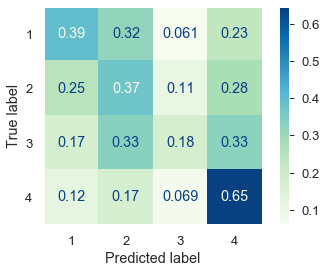



2. LGBMClassifier:
Accuracy: 0.40634567214027273
Quadratic Cohen-Kappa Score: 0.33800460082518624


Confusion Matrix: 



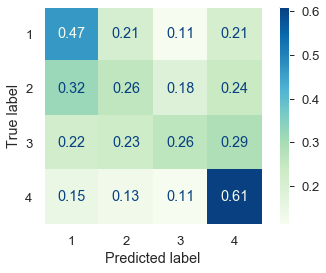



3. GradientBoostingClassifier:
Accuracy: 0.40634567214027273
Quadratic Cohen-Kappa Score: 0.32810895444806476


Confusion Matrix: 



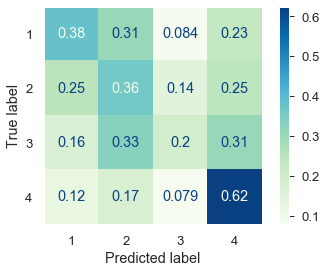



4. AdaBoostClassifier:
Accuracy: 0.3932646813247982
Quadratic Cohen-Kappa Score: 0.299514571619827


Confusion Matrix: 



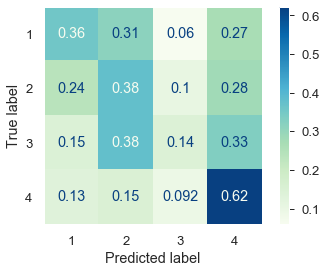



5. RandomForestClassifier:
Accuracy: 0.374617311438909
Quadratic Cohen-Kappa Score: 0.27564439065554325


Confusion Matrix: 



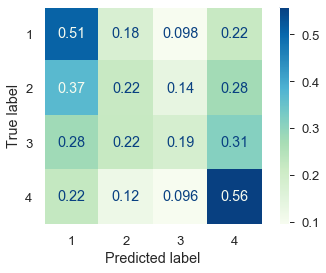



6. ExtraTreesClassifier:
Accuracy: 0.34567214027275256
Quadratic Cohen-Kappa Score: 0.23353226550180928


Confusion Matrix: 



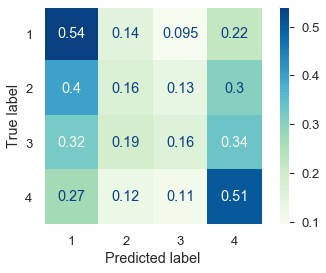



7. BaggingClassifier:
Accuracy: 0.406067353186752
Quadratic Cohen-Kappa Score: 0.326430783027141


Confusion Matrix: 



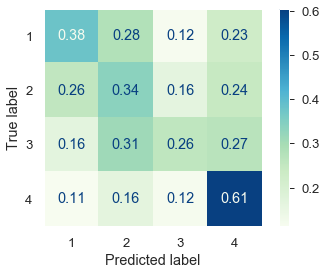



8. DecisionTreeClassifier:
Accuracy: 0.38658502644030057
Quadratic Cohen-Kappa Score: 0.3136040057742995


Confusion Matrix: 



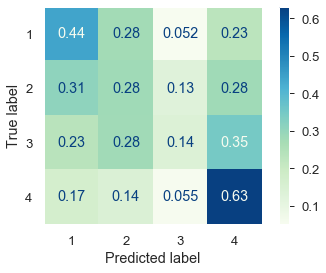



9. GaussianProcessClassifier:
Accuracy: 0.34873364876148066
Quadratic Cohen-Kappa Score: 0.23527134768637015


Confusion Matrix: 



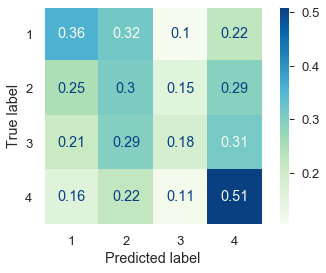

In [411]:
df_score = func.run_clf(classifiers, X_train_scaled, X_test_scaled, y_train, y_test)

In [412]:
pickle.dump(df_score, open("clf_scores_final.pkl", "wb"))

print("Estimator with the highest accuracy score: ")
display(df_score.sort_values("accuracy_score", ascending=False).head(1))

print("Estimator with the highest quadratic Cohen-Kappa score: ")
display(df_score.sort_values("quadratic_cohen_kappa_score", ascending=False).head(1))

Estimator with the highest accuracy score: 


estimator  accuracy_score  quadratic_cohen_kappa_score
0  XGBClassifier  0.414139        0.343726

Estimator with the highest quadratic Cohen-Kappa score: 


estimator  accuracy_score  quadratic_cohen_kappa_score
0  XGBClassifier  0.414139        0.343726

### Model Optimisation

Running GridSearchCV...
Done.
---------------------------------------------------------------------
Best Parameters: {'gamma': 1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.9}
---------------------------------------------------------------------
Accuracy score:  41.0 %
Quadratic Cohen-Kappa score:  31.0 %
---------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           1       0.40      0.38      0.39       830
           2       0.36      0.37      0.36      1007
           3       0.34      0.23      0.27       746
           4       0.48      0.61      0.54      1010

    accuracy                           0.41      3593
   macro avg       0.39      0.39      0.39      3593
weighted avg       0.40      0.41      0.40      3593

---------------------------------------------------------------------
Confusion Matrix: 



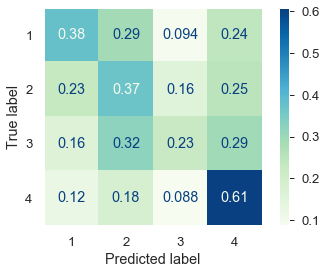

In [415]:
#Create hyperparameter options
param_grid = dict(max_depth=[3, 5, 7, 10],
                  n_estimators=[100, 200],
                  gamma=[0.01, 0.1, 0, 1, 10],
                  subsample=[0.8, 0.9, 1])

#Run GridSearchCV
xgb = XGBClassifier(booster="gbtree",
                    num_class=4,
                    random_state=42,
                    objective="multi:softmax")

cv_results_top10, best_model = func.run_GridSearchCV(X_train_scaled,
                                                     X_test_scaled, y_train,
                                                     y_test, xgb, param_grid)

pickle.dump(best_model, open("xgb_gscv_final.pkl", "wb"))

In [416]:
cv_results_top10

rank_test_score  \
91  1                 
85  2                 
82  3                 
34  4                 
67  5                 
7   6                 
60  7                 
90  8                 
94  9                 
31  10                

                                                                    params  \
91  {'gamma': 1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.9}     
85  {'gamma': 1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}      
82  {'gamma': 1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}      
34  {'gamma': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}    
67  {'gamma': 0, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.9}     
7   {'gamma': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}   
60  {'gamma': 0, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}      
90  {'gamma': 1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}     
94  {'gamma': 1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.9}     
31  {'gamma': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}    

    mean_train_score  std_train_score  mean_test_score  std_test_score  
91  0.903516          0.002456         0.418500         0.007144        
85  0.731608          0.004876         0.417201         0.009483        
82  0.657158          0.004723         0.416088         0.009227        
34  0.671329          0.005385         0.416088         0.006210        
67  0.953057          0.003569         0.415346         0.010094        
7   0.582197          0.004011         0.415345         0.004133        
60  0.764844          0.004139         0.414697         0.007070        
90  0.907598          0.002570         0.414419         0.011834        
94  0.944522          0.002001         0.414140         0.010221        
31  0.581292          0.003877         0.414139         0.002858

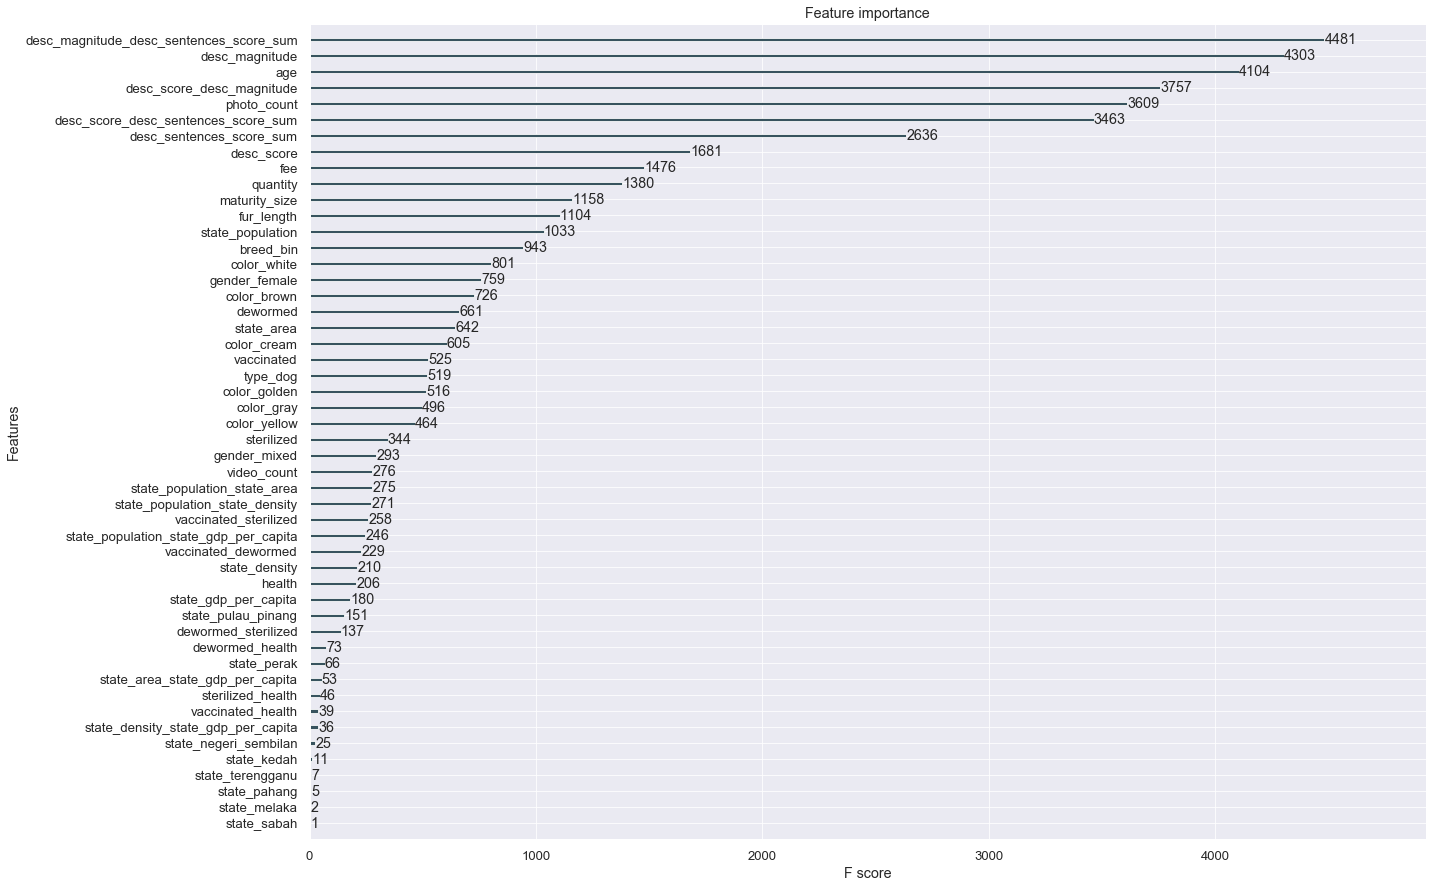

In [417]:
fig, ax = plt.subplots(figsize=(20,15))
xgboost.plot_importance(best_model, ax=ax);

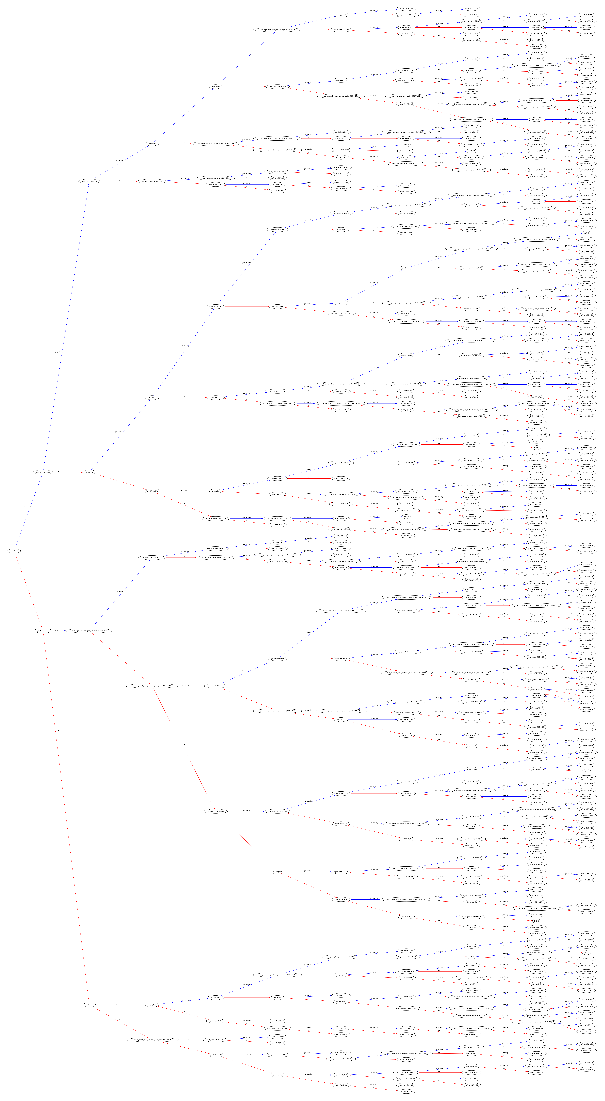

In [418]:
fig, ax = plt.subplots(figsize=(70,20))
xgboost.plot_tree(best_model, ax=ax, rankdir="LR");

Running GridSearchCV...
Done.
---------------------------------------------------------------------
Best Parameters: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
---------------------------------------------------------------------
Accuracy score:  41.0 %
Quadratic Cohen-Kappa score:  34.0 %
---------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           1       0.40      0.40      0.40       830
           2       0.35      0.35      0.35      1007
           3       0.35      0.21      0.26       746
           4       0.49      0.64      0.55      1010

    accuracy                           0.41      3593
   macro avg       0.40      0.40      0.39      3593
weighted avg       0.40      0.41      0.40      3593

---------------------------------------------------------------------
Confusion Matrix: 



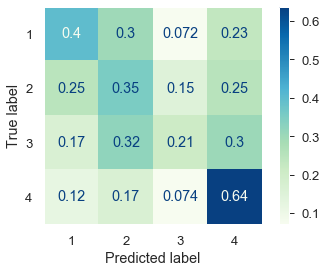

In [457]:
param_grid = dict(max_depth=[5, 6, 7],
                  n_estimators=[100, 200],
                  gamma=[0.01, 0.1, 0, 1],
                  learning_rate=[0.05, 0.1, 0.3])

#Run GridSearchCV
xgb_2 = XGBClassifier(booster="gbtree",
                      num_class=4,
                      random_state=42,
                      objective="multi:softmax",
                      subsample=0.9)

cv_results_top10_2, best_model_2 = func.run_GridSearchCV(
    X_train_scaled, X_test_scaled, y_train, y_test, xgb_2, param_grid)

pickle.dump(best_model_2, open("xgb_gscv_final_2.pkl", "wb"))

In [460]:
cv_results_top10_2

rank_test_score  \
64  1                 
5   2                 
61  3                 
25  4                 
21  5                 
40  6                 
3   7                 
6   8                 
41  9                 
22  10                

                                                                         params  \
64  {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}       
5   {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}   
61  {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}       
25  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}     
21  {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}    
40  {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}      
3   {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}   
6   {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}    
41  {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}      
22  {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}    

    mean_train_score  std_train_score  mean_test_score  std_test_score  
64  0.731608          0.004876         0.417201         0.009483        
5   0.759927          0.009329         0.416366         0.005284        
61  0.657158          0.004723         0.416088         0.009227        
25  0.671329          0.005385         0.416088         0.006210        
21  0.667223          0.006896         0.415809         0.005655        
40  0.657459          0.008467         0.415623         0.001683        
3   0.668082          0.006736         0.415531         0.006768        
6   0.582197          0.004011         0.415345         0.004133        
41  0.758744          0.008562         0.415253         0.006599        
22  0.657297          0.006691         0.415160         0.004668

Running GridSearchCV...
Done.
---------------------------------------------------------------------
Best Parameters: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
---------------------------------------------------------------------
Accuracy score:  41.0 %
Quadratic Cohen-Kappa score:  33.0 %
---------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           1       0.40      0.39      0.40       830
           2       0.36      0.35      0.36      1007
           3       0.35      0.21      0.26       746
           4       0.48      0.64      0.55      1010

    accuracy                           0.41      3593
   macro avg       0.40      0.40      0.39      3593
weighted avg       0.40      0.41      0.40      3593

---------------------------------------------------------------------
Confusion Matrix: 



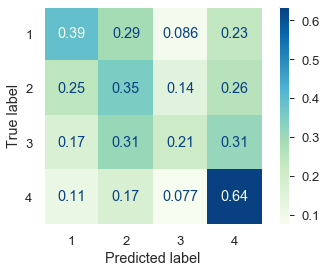

In [461]:
param_grid = dict(max_depth=[3, 4, 5],
                  n_estimators=[100, 200],
                  gamma=[0.01, 0.1, 0, 1],
                  learning_rate=[0.05, 0.07, 0.1])

#Run GridSearchCV
xgb_3 = XGBClassifier(booster="gbtree",
                      num_class=4,
                      random_state=42,
                      objective="multi:softmax",
                      subsample=0.9)

cv_results_top10_3, best_model_3 = func.run_GridSearchCV(
    X_train_scaled, X_test_scaled, y_train, y_test, xgb_3, param_grid)

pickle.dump(best_model_3, open("xgb_gscv_final_3.pkl", "wb"))

In [508]:
cv_results_top10_3

rank_test_score  \
71  1                 
35  2                 
16  3                 
69  4                 
11  5                 
29  6                 
34  7                 
5   8                 
65  9                 
23  10                

                                                                         params  \
71  {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}       
35  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}     
16  {'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}    
69  {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}       
11  {'gamma': 0.01, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 200}   
29  {'gamma': 0.1, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 200}    
34  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}     
5   {'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}   
65  {'gamma': 1, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 200}      
23  {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}    

    mean_train_score  std_train_score  mean_test_score  std_test_score  
71  0.657158          0.004723         0.416088         0.009227        
35  0.671329          0.005385         0.416088         0.006210        
16  0.582197          0.004011         0.415345         0.004133        
69  0.570600          0.004104         0.414603         0.004514        
11  0.623319          0.005934         0.414510         0.005086        
29  0.622924          0.004080         0.414417         0.004327        
34  0.581292          0.003877         0.414139         0.002858        
5   0.582429          0.004003         0.414139         0.006341        
65  0.613508          0.004869         0.414047         0.006020        
23  0.582939          0.004357         0.413768         0.004794

Running GridSearchCV...
Done.
---------------------------------------------------------------------
Best Parameters: {'booster': 'gbtree', 'gamma': 1, 'max_depth': 4, 'n_estimators': 200}
---------------------------------------------------------------------
Accuracy score:  41.0 %
Quadratic Cohen-Kappa score:  33.0 %
---------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           1       0.40      0.38      0.39       830
           2       0.36      0.38      0.37      1007
           3       0.35      0.18      0.24       746
           4       0.47      0.63      0.54      1010

    accuracy                           0.41      3593
   macro avg       0.40      0.39      0.39      3593
weighted avg       0.40      0.41      0.40      3593

---------------------------------------------------------------------
Confusion Matrix: 



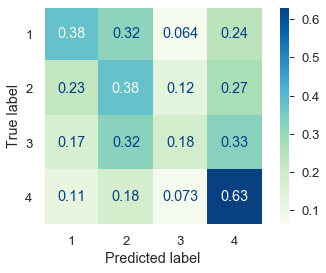

In [509]:
param_grid = dict(max_depth=[3, 4],
                  n_estimators=[100, 200],
                  booster=["gbtree", "dart"],
                  gamma=[0.1, 1])

#Run GridSearchCV
xgb_4 = XGBClassifier(num_class=4,
                      random_state=42,
                      objective="multi:softmax",
                      subsample=0.9,
                      learning_rate=0.1)

cv_results_top10_4, best_model_4 = func.run_GridSearchCV(
    X_train_scaled, X_test_scaled, y_train, y_test, xgb_4, param_grid)

pickle.dump(best_model_4, open("xgb_gscv_final_4.pkl", "wb"))

In [510]:
cv_results_top10_4

rank_test_score  \
7   1                 
3   2                 
2   3                 
11  4                 
6   5                 
14  6                 
10  7                 
15  8                 
1   9                 
5   10                

                                                                      params  \
7   {'booster': 'gbtree', 'gamma': 1, 'max_depth': 4, 'n_estimators': 200}     
3   {'booster': 'gbtree', 'gamma': 0.1, 'max_depth': 4, 'n_estimators': 200}   
2   {'booster': 'gbtree', 'gamma': 0.1, 'max_depth': 4, 'n_estimators': 100}   
11  {'booster': 'dart', 'gamma': 0.1, 'max_depth': 4, 'n_estimators': 200}     
6   {'booster': 'gbtree', 'gamma': 1, 'max_depth': 4, 'n_estimators': 100}     
14  {'booster': 'dart', 'gamma': 1, 'max_depth': 4, 'n_estimators': 100}       
10  {'booster': 'dart', 'gamma': 0.1, 'max_depth': 4, 'n_estimators': 100}     
15  {'booster': 'dart', 'gamma': 1, 'max_depth': 4, 'n_estimators': 200}       
1   {'booster': 'gbtree', 'gamma': 0.1, 'max_depth': 3, 'n_estimators': 200}   
5   {'booster': 'gbtree', 'gamma': 1, 'max_depth': 3, 'n_estimators': 200}     

    mean_train_score  std_train_score  mean_test_score  std_test_score  
7   0.570600          0.004104         0.414603         0.004514        
3   0.576747          0.004336         0.413397         0.006600        
2   0.516699          0.002774         0.410428         0.003231        
11  0.579344          0.003436         0.409779         0.004264        
6   0.514913          0.003557         0.409407         0.004159        
14  0.515702          0.002588         0.409036         0.006613        
10  0.517859          0.001647         0.408850         0.005794        
15  0.572711          0.003402         0.407645         0.005903        
1   0.506053          0.001917         0.407552         0.006550        
5   0.502806          0.000628         0.407552         0.005851

### Best Model

In [529]:
xgb_best = XGBClassifier(num_class=4,
                         random_state=42,
                         objective="multi:softmax",
                         subsample=0.9,
                         learning_rate=0.1,
                         gamma=1,
                         booster='gbtree',
                         max_depth=5,
                         n_estimators=200)

---------------------------------------------------------------------
Accuracy score:  41.0 %
Quadratic Cohen-Kappa score:  36.0 %
---------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           1       0.41      0.41      0.41       652
           2       0.34      0.35      0.35       793
           3       0.34      0.19      0.25       614
           4       0.49      0.65      0.56       816

    accuracy                           0.41      2875
   macro avg       0.40      0.40      0.39      2875
weighted avg       0.40      0.41      0.40      2875

---------------------------------------------------------------------
Confusion Matrix: 



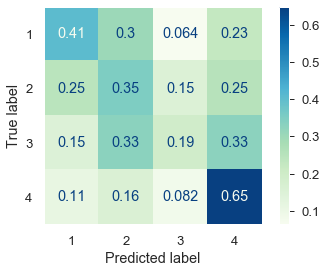

In [530]:
xgb_best.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled,y_test)], 
    eval_metric="merror", verbose=False)

func.evaluate(xgb_best, X_train_scaled, X_test_scaled, y_train, y_test)

In [531]:
pickle.dump(xgb_best, open("xgb_best.pkl", "wb"))

In [536]:
xgb_best = XGBClassifier(num_class=4,
                         random_state=42,
                         objective="multi:softmax",
                         subsample=0.9,
                         learning_rate=0.1,
                         gamma=1,
                         booster='gbtree',
                         max_depth=5,
                         n_estimators=200)

---------------------------------------------------------------------
Accuracy score:  41.0 %
Quadratic Cohen-Kappa score:  36.0 %
---------------------------------------------------------------------
Classification Report: 
               precision    recall  f1-score   support

           1       0.41      0.41      0.41       652
           2       0.34      0.35      0.35       793
           3       0.34      0.19      0.25       614
           4       0.49      0.65      0.56       816

    accuracy                           0.41      2875
   macro avg       0.40      0.40      0.39      2875
weighted avg       0.40      0.41      0.40      2875

---------------------------------------------------------------------
Confusion Matrix: 



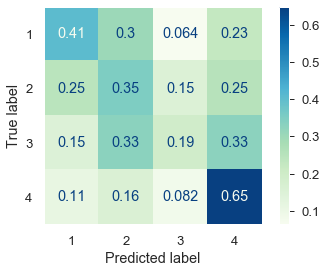

In [537]:
xgb_best.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled,y_test)], 
    eval_metric="merror", verbose=False)

func.evaluate(xgb_best, X_train_scaled, X_test_scaled, y_train, y_test)

### Feature Importance

In [422]:
shap.initjs()

In [469]:
explainer = shap.TreeExplainer(best_model)
pickle.dump(explainer, open("explainer_list.pkl", "wb"))
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0)
pickle.dump(X_scaled, open("X.pkl", "wb"))
shap_values = explainer.shap_values(X_scaled)
pickle.dump(shap_values, open("shap_list.pkl", "wb"))

In [482]:
def shap_force_plot(target_class, i, X):
    class_index = target_class - 1
    explainer_list = pickle.load(open("explainer_list.pkl", "rb"))
    shap_list = pickle.load(open("shap_list.pkl", "rb"))
    display(shap.force_plot(explainer_list.expected_value[class_index],
                    shap_list[class_index][i, :], X.iloc[i, :]))

def shap_summary_plot(target_class, X):
    class_index = target_class - 1
    shap_list = pickle.load(open("shap_list.pkl", "rb"))
    display(shap.summary_plot(shap_list[class_index], X))

In [484]:
shap_force_plot(3, 0, X_scaled)
y.adoption_speed.loc[0]

In [506]:
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0, ignore_index=True)
X_scaled

age  video_count  photo_count  quantity       fee  \
0      0.007843  0.0          0.033333     0.000000  0.000000   
1      0.007843  0.0          0.033333     0.000000  0.026667   
2      0.007843  0.0          0.033333     0.157895  0.000000   
3      0.011765  0.0          0.033333     0.000000  0.000000   
4      0.015686  0.0          0.266667     0.210526  0.000000   
...         ...  ...               ...          ...       ...   
14367  0.011765  0.0          0.100000     0.000000  0.000000   
14368  0.035294  0.0          0.233333     0.000000  0.000000   
14369  0.047059  0.0          0.233333     0.000000  0.000000   
14370  0.070588  0.0          0.100000     0.052632  0.000000   
14371  0.003922  0.0          0.000000     0.263158  0.000000   

       state_population  state_area  state_density  state_gdp_per_capita  \
0      1.000000          0.064434    0.097199       0.353000               
1      0.269406          0.007695    0.214468       0.371234               
2      0.269406          0.007695    0.214468       0.371234               
3      0.289501          0.001222    1.000000       1.000000               
4      1.000000          0.064434    0.097199       0.353000               
...         ...               ...         ...            ...               
14367  1.000000          0.064434    0.097199       0.353000               
14368  1.000000          0.064434    0.097199       0.353000               
14369  1.000000          0.064434    0.097199       0.353000               
14370  1.000000          0.064434    0.097199       0.353000               
14371  0.171196          0.053032    0.019470       0.286735               

       state_population_state_area  state_population_state_density  \
0      0.145588                     0.328933                         
1      0.005264                     0.199063                         
2      0.005264                     0.199063                         
3      0.001287                     1.000000                         
4      0.145588                     0.328933                         
...         ...                          ...                         
14367  0.145588                     0.328933                         
14368  0.145588                     0.328933                         
14369  0.145588                     0.328933                         
14370  0.145588                     0.328933                         
14371  0.022110                     0.009455                         

       state_population_state_gdp_per_capita  state_area_state_density  \
0      1.000000                               1.000000                   
1      0.275676                               0.269393                   
2      0.275676                               0.269393                   
3      0.689341                               0.289377                   
4      1.000000                               1.000000                   
...         ...                                    ...                   
14367  1.000000                               1.000000                   
14368  1.000000                               1.000000                   
14369  1.000000                               1.000000                   
14370  1.000000                               1.000000                   
14371  0.140879                               0.170967                   

       state_area_state_gdp_per_capita  state_density_state_gdp_per_capita  \
0      0.062570                         0.041892                             
1      0.007544                         0.095946                             
2      0.007544                         0.095946                             
3      0.003432                         1.000000                             
4      0.062570                         0.041892                             
...         ...                              ...                             
14367  0.062570                         0.

In [499]:
X_scaled.iloc[0,:]

age                                        0.007843
video_count                                0.000000
photo_count                                0.033333
quantity                                   0.000000
fee                                        0.000000
state_population                           1.000000
state_area                                 0.064434
state_density                              0.097199
state_gdp_per_capita                       0.353000
state_population_state_area                0.145588
state_population_state_density             0.328933
state_population_state_gdp_per_capita      1.000000
state_area_state_density                   1.000000
state_area_state_gdp_per_capita            0.062570
state_density_state_gdp_per_capita         0.041892
desc_score                                 0.500000
desc_magnitude                             0.003125
desc_sentences_score_sum                   0.245614
desc_score_desc_magnitude                  0.171975
desc_score_d

In [494]:
# y.adoption_speed.loc[0]
best_model.predict()

ValueError: feature_names mismatch: ['age', 'video_count', 'photo_count', 'quantity', 'fee', 'state_population', 'state_area', 'state_density', 'state_gdp_per_capita', 'state_population_state_area', 'state_population_state_density', 'state_population_state_gdp_per_capita', 'state_area_state_density', 'state_area_state_gdp_per_capita', 'state_density_state_gdp_per_capita', 'desc_score', 'desc_magnitude', 'desc_sentences_score_sum', 'desc_score_desc_magnitude', 'desc_score_desc_sentences_score_sum', 'desc_magnitude_desc_sentences_score_sum', 'maturity_size', 'fur_length', 'breed_bin', 'color_brown', 'color_cream', 'color_golden', 'color_gray', 'color_white', 'color_yellow', 'state_kedah', 'state_kelantan', 'state_kuala_lumpur', 'state_labuan', 'state_melaka', 'state_negeri_sembilan', 'state_pahang', 'state_perak', 'state_pulau_pinang', 'state_sabah', 'state_sarawak', 'state_selangor', 'state_terengganu', 'type_dog', 'gender_female', 'gender_mixed', 'vaccinated', 'dewormed', 'sterilized', 'health', 'vaccinated_dewormed', 'vaccinated_sterilized', 'vaccinated_health', 'dewormed_sterilized', 'dewormed_health', 'sterilized_health'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55']
expected sterilized_health, dewormed, state_labuan, state_population_state_gdp_per_capita, fee, color_white, breed_bin, desc_score_desc_magnitude, video_count, vaccinated, sterilized, vaccinated_health, state_melaka, state_pahang, photo_count, state_pulau_pinang, vaccinated_dewormed, type_dog, state_area, desc_score_desc_sentences_score_sum, color_cream, quantity, state_perak, dewormed_health, state_selangor, state_terengganu, desc_sentences_score_sum, state_kelantan, state_population_state_density, state_population, state_density_state_gdp_per_capita, color_gray, state_kuala_lumpur, desc_score, color_brown, state_kedah, state_density, age, desc_magnitude_desc_sentences_score_sum, desc_magnitude, health, state_area_state_gdp_per_capita, dewormed_sterilized, state_sabah, state_gdp_per_capita, maturity_size, color_golden, state_negeri_sembilan, state_area_state_density, state_population_state_area, gender_female, gender_mixed, fur_length, color_yellow, vaccinated_sterilized, state_sarawak in input data
training data did not have the following fields: f15, f34, f25, f47, f36, f40, f16, f41, f11, f27, f31, f49, f18, f46, f4, f26, f32, f23, f22, f24, f20, f35, f33, f17, f12, f29, f38, f9, f3, f52, f0, f5, f39, f42, f28, f14, f54, f7, f45, f19, f30, f55, f37, f44, f50, f43, f1, f13, f48, f53, f2, f10, f21, f8, f6, f51

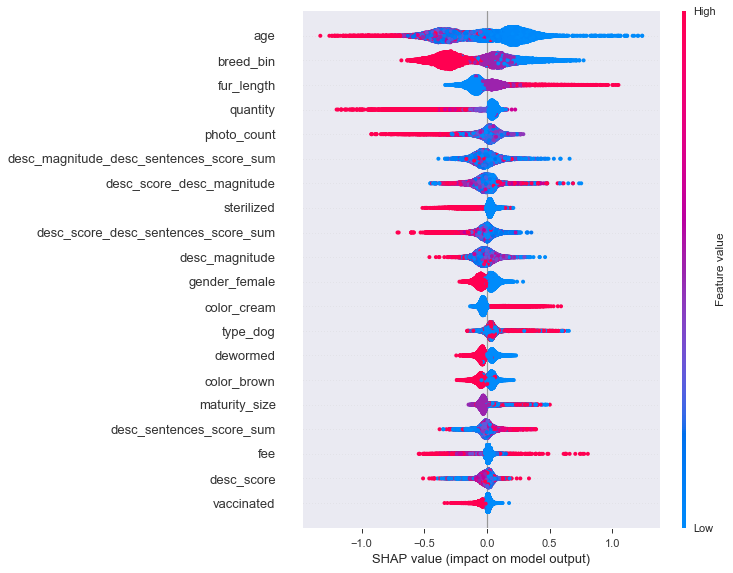

None

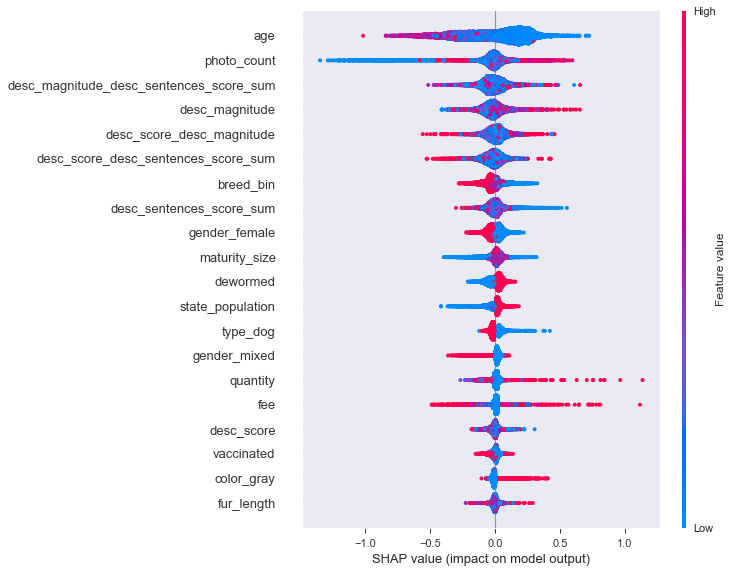

None

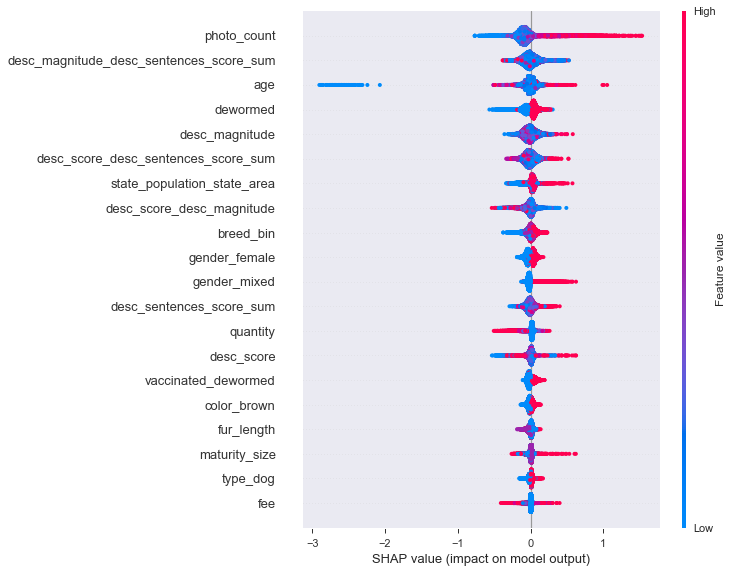

None

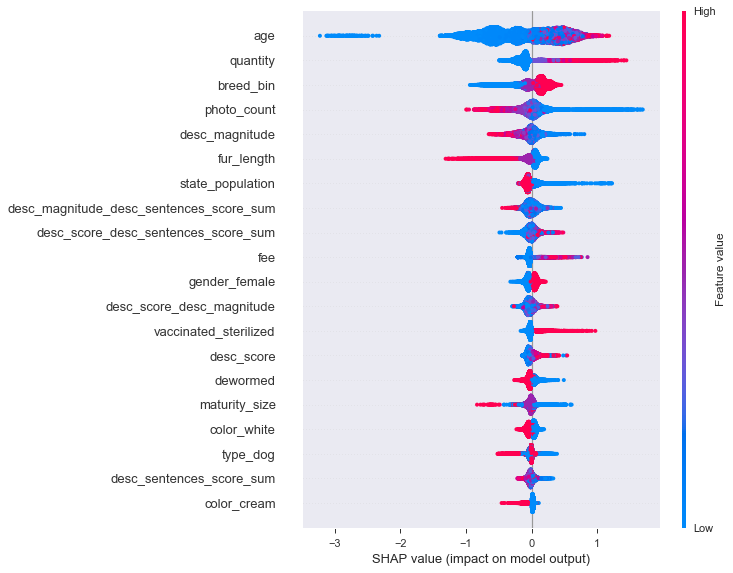

None

In [483]:
for i in range(1,5):
    shap_summary_plot(i, X_scaled)

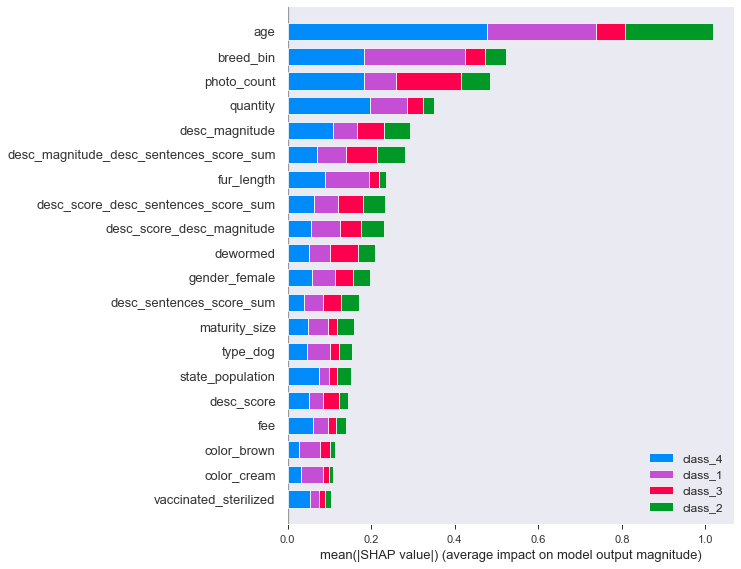

In [453]:
shap.summary_plot(shap_values, X_scaled, class_names=["class_1","class_2","class_3","class_4"])

# Recommend Listing based on Images

In [ ]:
pets_images = pd.read_csv("pets_model.csv")
to_exclude = ['description', 'desc_score', 'desc_magnitude', 'population', 'area',
       'density', 'gdp_per_capita']
pets_images = pre.drop_columns(pets_images, ['description', 'desc_score', 'desc_magnitude', 'population', 'area',
       'density', 'gdp_per_capita'])
pets_images.info()

In [ ]:
pets_breeds = pd.read_csv("pets.csv")[["pet_id", "breed1", "breed1_desc", "breed2", "breed2_desc"]]
pets_breeds.info()

In [ ]:
# images_orig_path = "dataset/petfinder-adoption-prediction/train_images"
# image_files = []

# for r, d, f in os.walk(images_orig_path):  # r=root, d=directories, f = files
#     for file in f:
#         if ".jpg" in file:
#             image_files.append(os.path.join(file))

# image_files[:5]

In [ ]:
# images = pd.DataFrame(data = image_files, columns = ["filename"])
# images["pet_id"] = images["filename"].map(lambda x: str(x)[:9])
# images = pd.merge(images, pets, on="pet_id", how="left")[["filename", "pet_id", "type"]]

# print("There are ",len(images.drop_duplicates("pet_id")), " pets with images.")
# print("There are a total of ",len(images), " pet images.")
# images.head()

In [ ]:
# images_dog = list(images.query("type == 1").filename)
# images_cat = list(images.query("type == 2").filename)

# dog_folder = "dataset/images/dog/"
# cat_folder = "dataset/images/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)

In [ ]:
# images_dog = list(images.drop_duplicates("pet_id").query("type == 1").filename)
# images_cat = list(images.drop_duplicates("pet_id").query("type == 2").filename)

# dog_folder = "dataset/images_unique/dog/"
# cat_folder = "dataset/images_unique/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)